In [1]:
println("Hello super people!")

Hello super people!


In [2]:
using Random, Plots, Statistics, Combinatorics, LaTeXStrings, CSV, DataFrames, StatsBase


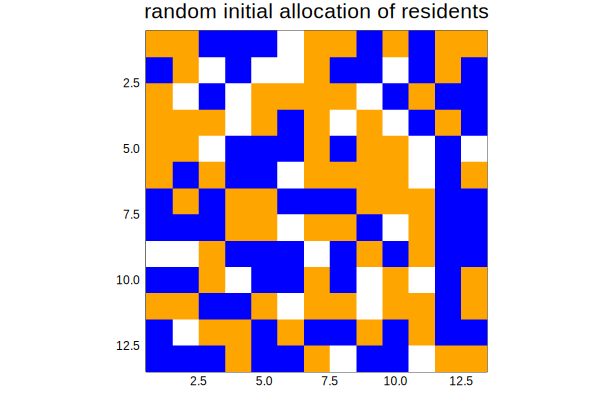

In [347]:

#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 13
CELL_COUNT = GRID_SIZE^2

THRESHOLD_SAME = 4
THRESHOLD_EDGE = 3
THRESHOLD_CORNER = 2

PP = 5

MM = 100#number of simulations
TT = 30#number of time points in simulation


yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
empty_count = CELL_COUNT - yellow_count - blue_count

#the total number of possible configurations
CELLS_SPACE_SIZE = multinomial(BigInt(yellow_count),BigInt(blue_count),BigInt(empty_count))
#println(CELLS_SPACE_SIZE)

#boltzmann constant
k_b = 1.380649*10^-23


empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

start_grid = shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h = heatmap(start_grid,title="random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


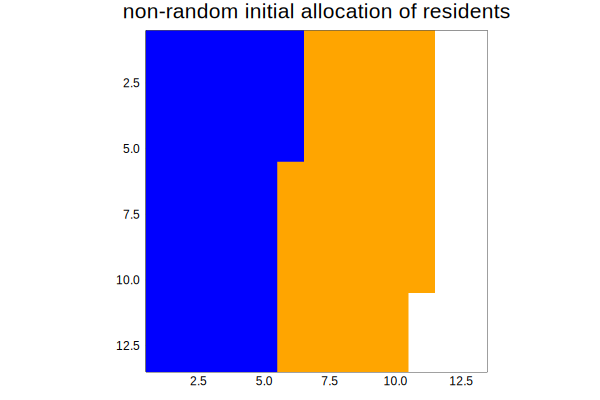

In [4]:
savefig(h,"figs/randomAllocationInit.png")

yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

set_grid = empty_grid#shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h2 = heatmap(set_grid,title="non-random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

In [5]:
savefig(h2,"figs/setAllocation.png")

#macrostate function mapping (eg, what is the total satisfaction of the residents overall the cells, total sum from zero to max)
#function overall_satisfaction(start_grid)

function grid_satisfaction(grid)
    cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            
            t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_satisfaction,tmpBinary)
        end
    end
    return sum(cell_satisfaction)
end

function thresholdFN(cellSurroundArray,cellType,row,col)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end
function cell_surround_arrayTMP(grid,row,col)
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end

R_MAX = grid_satisfaction(set_grid)
println("set grid satisfaction value MAX=",R_MAX)
R_START = grid_satisfaction(start_grid)
println("set grid satisfaction value START=",R_START)


set grid satisfaction value MAX=140
set grid satisfaction value START=57


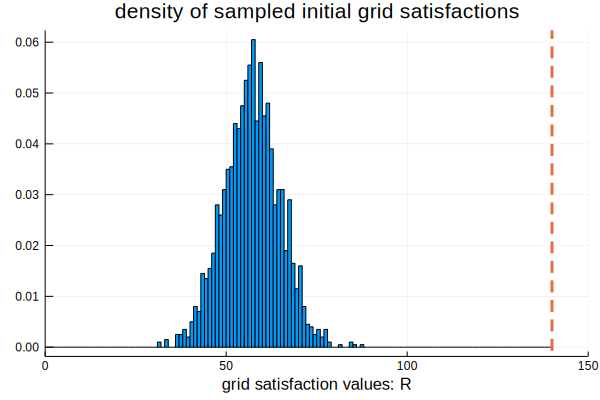

In [6]:
#sample the random intializations and investigate 
function make_random_grid()
    empty_grid = zeros(GRID_SIZE,GRID_SIZE)
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    random_grid = shuffle(empty_grid)
    return random_grid
end
numberOfRandomSamples = 2000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]
normedRandomSatisfactions = randomSatisfactions ./ sum(randomSatisfactions)
pltHist = histogram(randomSatisfactions,bins=0:1:R_MAX,normalize=:probability,xlim=(0,R_MAX+10),title="density of sampled initial grid satisfactions",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

In [7]:
savefig(pltHist,"figs/histogramOfSampledInitSatisfactions.png")

#llok at not the grid level satisfaction but the single cell level satisfaction
function cell_surround_array(grid,row,col)
    #if((row==1 && col==1))#top left corner
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end
  
    return cell_surrounding
end

function is_cell_satisfied(grid,row,col)
    cellSurroundArray = cell_surround_array(grid,row,col)
    #println(cellSurroundArray)
    cellType = grid[row,col]
    #println(cellType)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = is_cell_satisfied(start_grid,8,7)
#println(cell_satisfied)
 


is_cell_satisfied (generic function with 1 method)

In [8]:
#testing for if a cell would be satisfied if it were placed there
function would_cell_be_satisfied(grid,row,col,cellType)
    cellSurroundArray = cell_surround_array(grid,row,col)    
    #println(cellSurroundArray)
    homogeneity = length(findall(cellType .== cellSurroundArray))    
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = would_cell_be_satisfied(start_grid,7,9,start_grid[2,2])
#println(cell_satisfied)
 

would_cell_be_satisfied (generic function with 1 method)

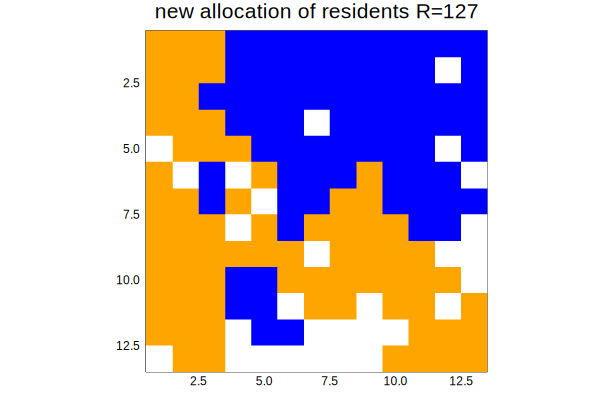

In [9]:
#get non-empty cell set
#Search for an unsatisfied iteratively in all the cells through a shuffled list
#find all empty cells
#shuffle the list of the empty cells
#see if the cell would_cell_be_satisfied in any of the cells in sequence
#no, move on to the next cell
#if yes, change the original cell position to empty and make the new cell the cell type
#loop till all non-empty cells are tested

function move_cells_for_satisfaction(grid)
    
    newGrid = deepcopy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]    
    #R_START = grid_satisfaction(grid)

    #remove (skip) the satisfied, don't include them in the rotation on each iteration
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)   
    
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])
        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            moved = false
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)  
                    
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    moved = true
                    break
                end                
            end   
            #=if(moved == false)
                println("cell at i=$(nzc[1]) and j=$(nzc[2]) did not move")
            end=#
        end       
    end
    
    return newGrid
end

newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)
#println(satisfiedOneGrid)
h3 = heatmap(newGrid,title="new allocation of residents R=$(satisfiedOneGrid)",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


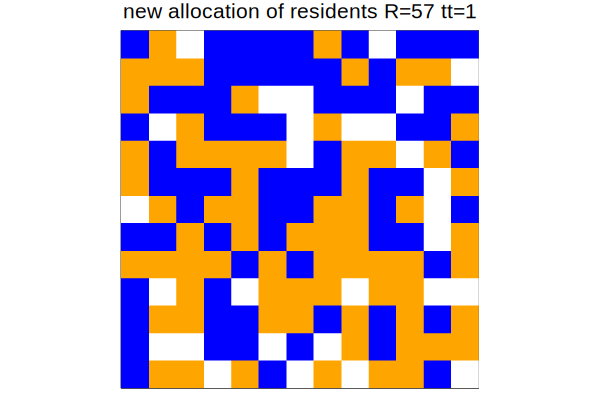

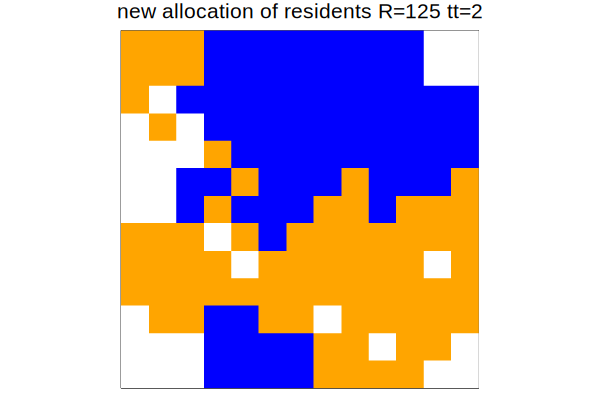

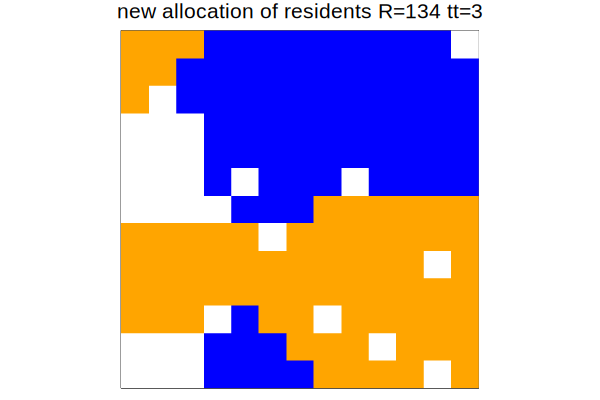

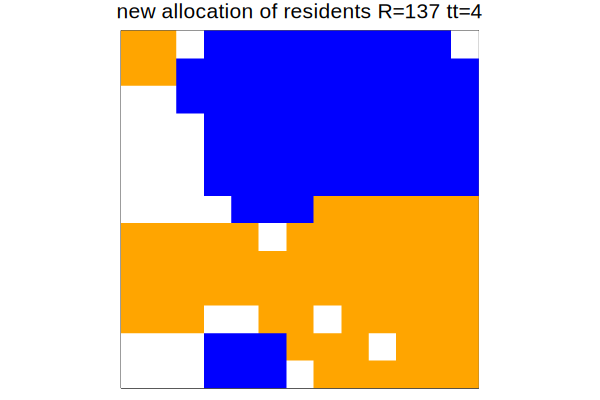

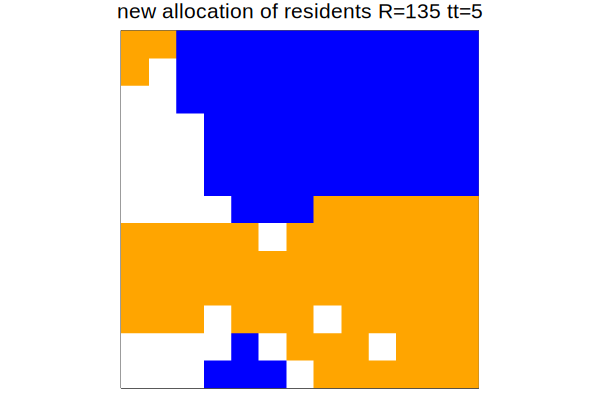

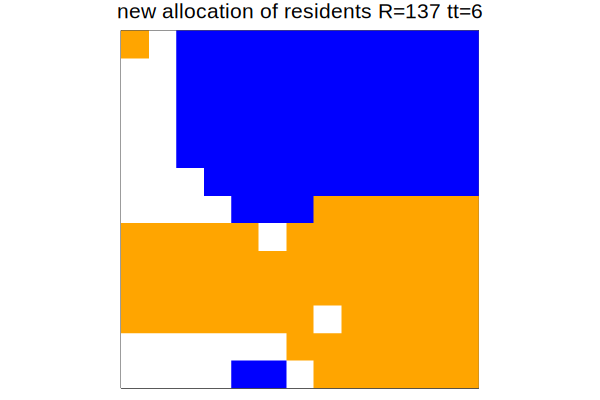

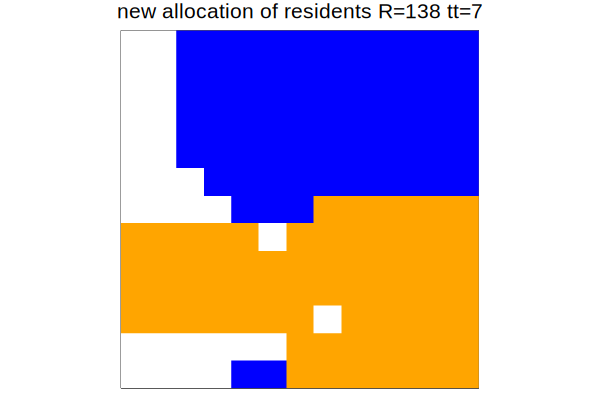

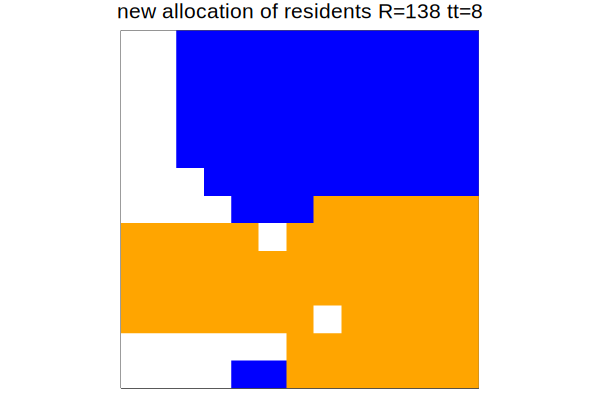

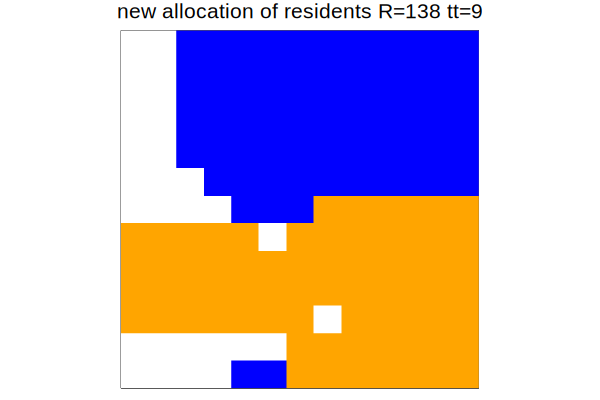

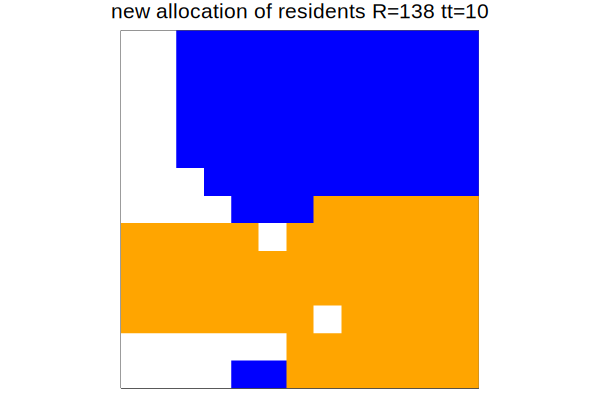

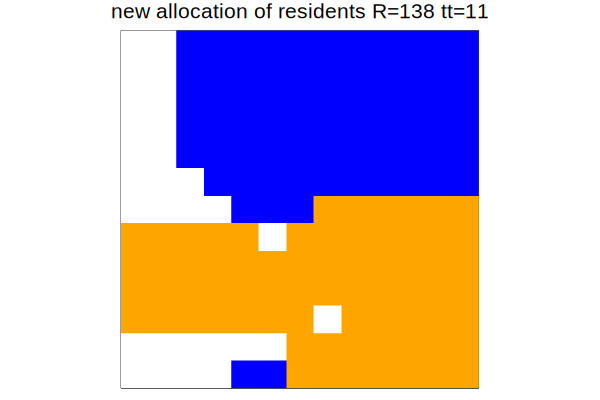

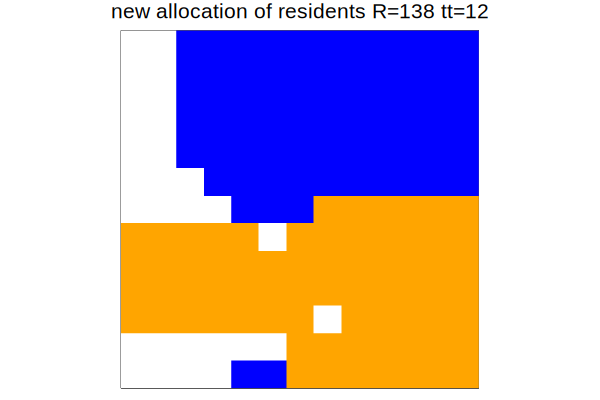

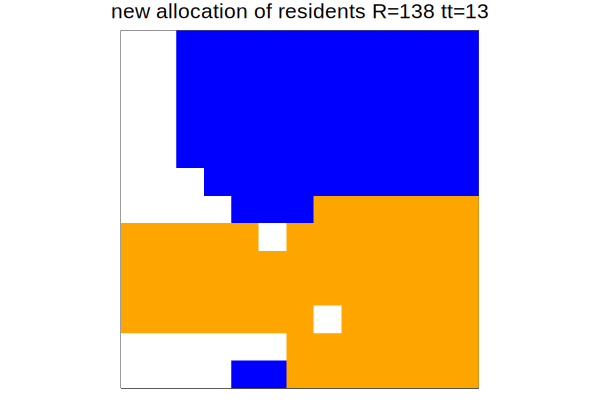

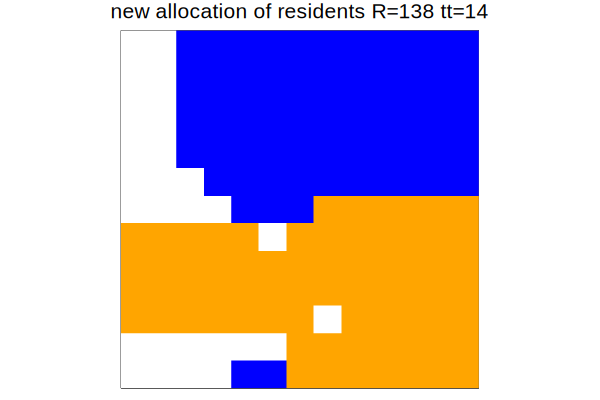

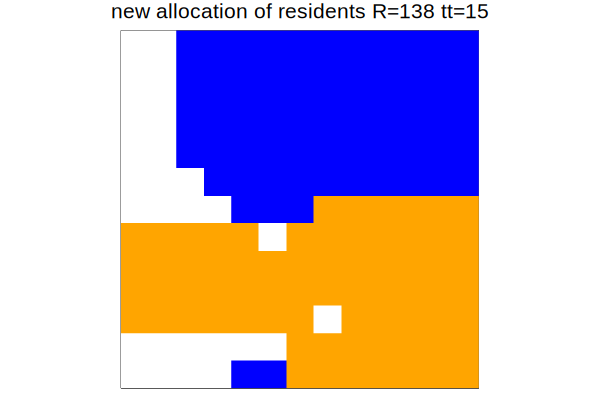

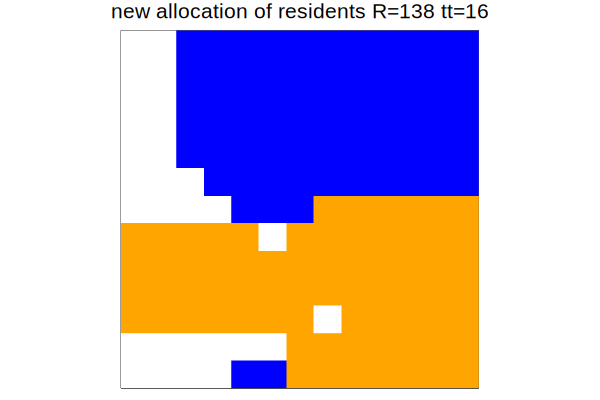

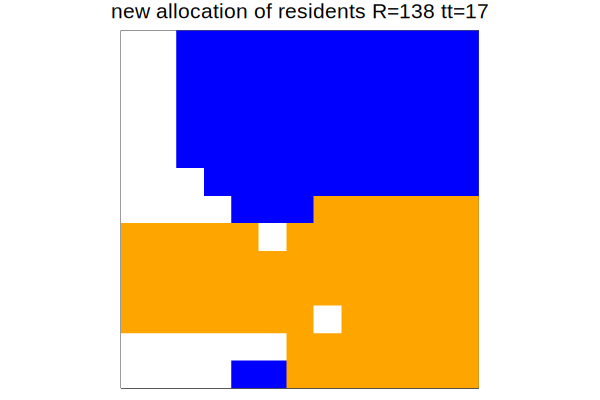

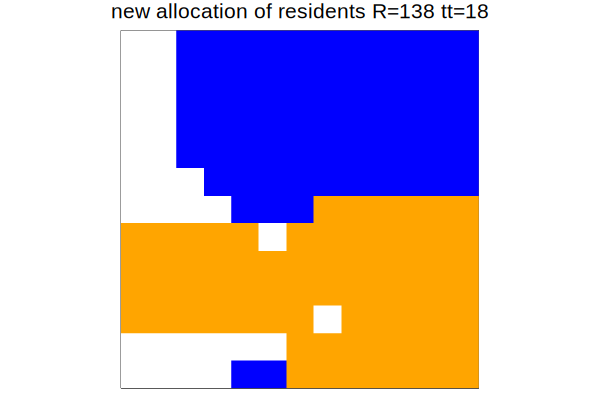

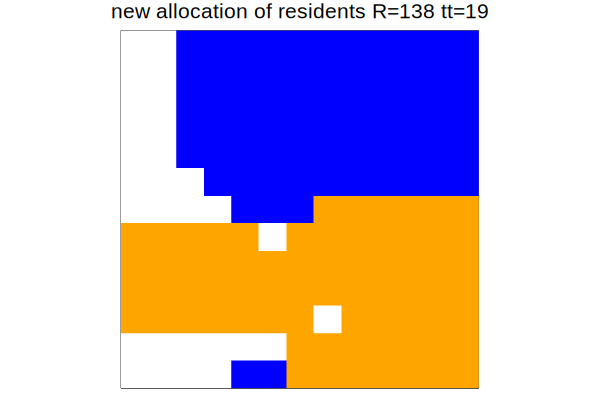

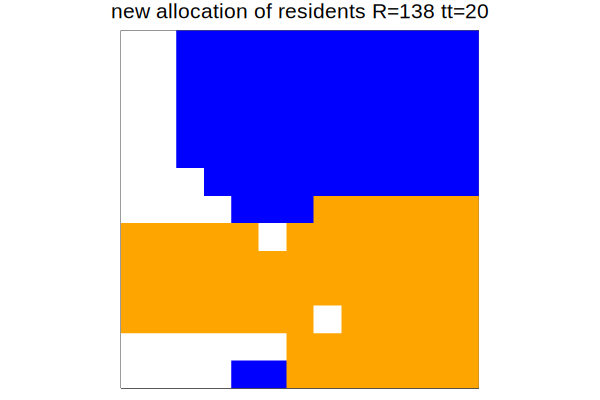

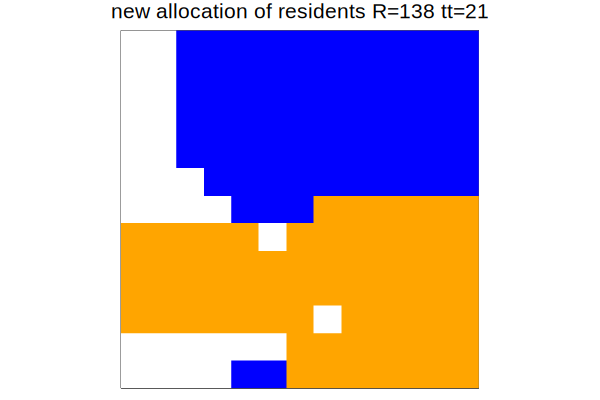

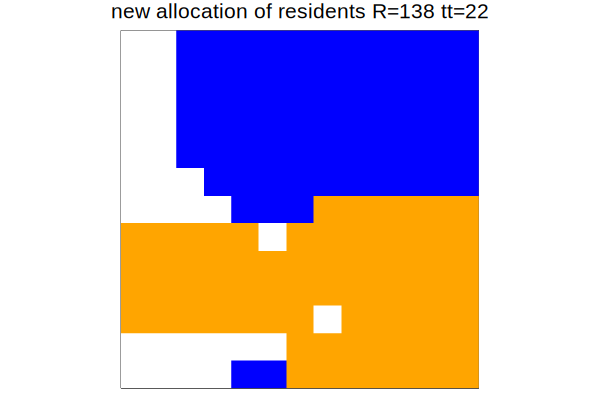

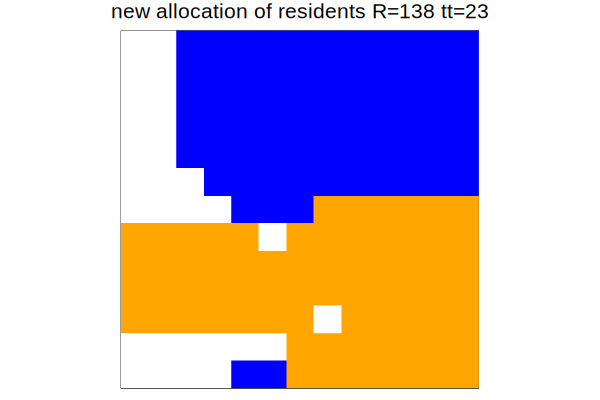

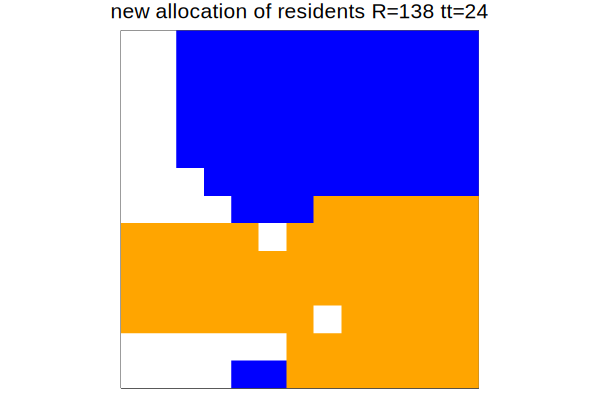

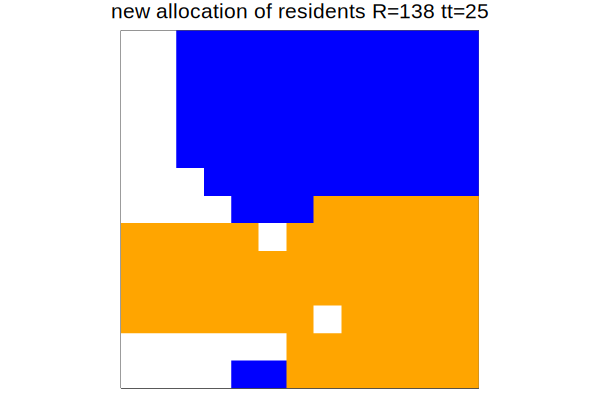

In [10]:
savefig(h3,"figs/newAllocation.png")


gridDict = Dict()
gridDict[1] = start_grid

for tt in 2:TT
gridDict[tt] = move_cells_for_satisfaction(gridDict[tt-1])
end
#println(gridDict)

hArray = []

for tt in 1:TT
    #println("tt=$tt")
    R = grid_satisfaction(gridDict[tt])
    hm = heatmap(gridDict[tt],title="new allocation of residents R=$(R) tt=$tt",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))
    display(hm)
    savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
end



[57, 125, 134, 137, 135, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138]
Array{Int64,1}


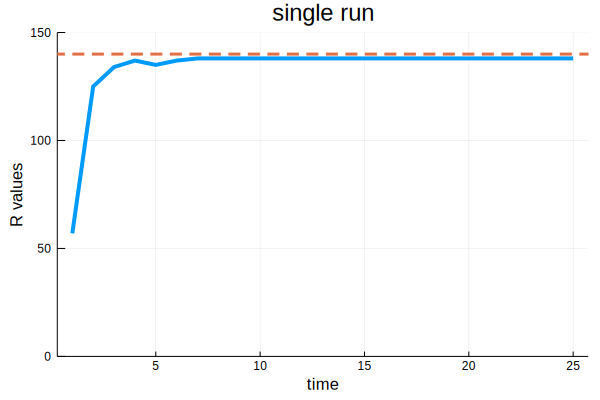

In [11]:

traceR = Int[]

for tt in 1:TT    
    append!(traceR,grid_satisfaction(gridDict[tt]))    
end
println(traceR)
println(typeof(traceR))
plt = plot(traceR,ylim=(0,R_MAX+10),leg=false,linewidth=4,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")

#plot(traceR,ylim=(0,R_MAX+10),leg=false,guidefont=14,linewidth=4,xtickfontsize=10,ytickfontsize=10,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")
hline!([R_MAX],line=(3,:dash),leg=false)

(25, 10)
[54.5; 125.7; 134.4; 136.7; 137.9; 138.8; 138.9; 138.9; 138.9; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1; 139.1]


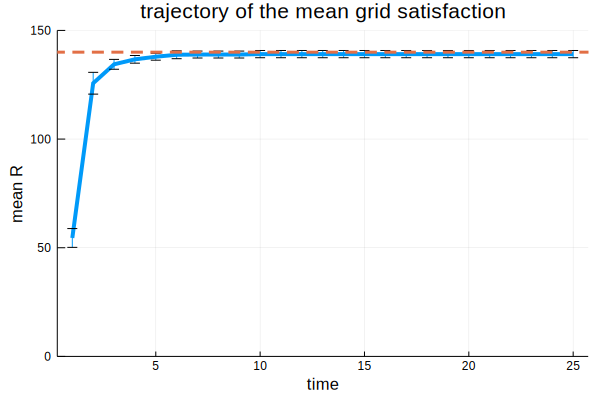

In [12]:
savefig(plt,"figs/singleRun.png")


simulationRvals = zeros(TT,MM)
for mm in 1:MM
    newGrid = shuffle(empty_grid)
    traceR = []
    append!(traceR,grid_satisfaction(newGrid))#initial time zero point
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        append!(traceR,grid_satisfaction(newGrid))
    end
    simulationRvals[:,mm] = traceR[:]

end
    

println(size(simulationRvals))
println(mean(simulationRvals,dims=2))
plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)

In [13]:
savefig(plt,"figs/multipleRun.png")


println(simulationRvals[end,:])

[140.0, 140.0, 140.0, 140.0, 140.0, 140.0, 140.0, 136.0, 139.0, 136.0]


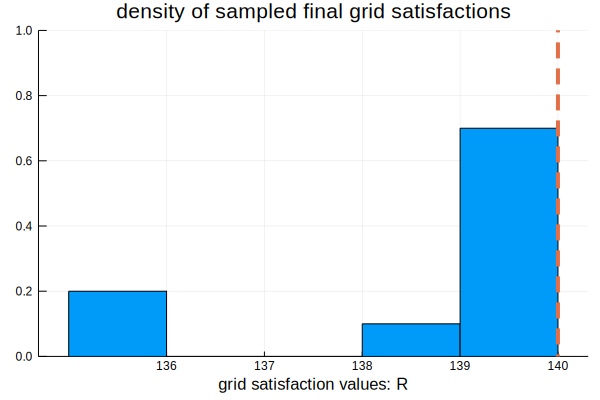

In [14]:
#get the histogram of the final values

pltHist = histogram(simulationRvals[end,:] .- 1,ylim=(0,1.0),xticks = (minimum(simulationRvals[end,:]):maximum(simulationRvals[end,:])) ,normalize=:probability,title="density of sampled final grid satisfactions",xlabel="grid satisfaction values: R",leg=false)#,xlim=(0,R_MAX+10)
vline!([R_MAX],line=(4,:dash),leg=false)



In [15]:
savefig(pltHist,"figs/finalHistRvals.png")


#sample random microstates
numberOfRandomSamples = 15000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]

#set the macrostate count array to those random allocations 
sampleCountsR = [length(findall(randomSatisfactions .== R)) for R in 1:R_MAX]
#println(sampleCountsR)
replace!(sampleCountsR,0=>1)
#println(sampleCountsR)
sampleProbR = sampleCountsR ./ sum(sampleCountsR)
#println(sampleProbR)
#println(sum(sampleProbR))

#The cellspace for the macrostates is the multiple of the probability
sampleOmegaR = sampleProbR .* CELLS_SPACE_SIZE
#println(sampleOmegaR)


println(sampleOmegaR)
println(size(sampleOmegaR))

BigFloat[2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 6.69384e+69, 4.46256e+69, 8.92512e+69, 1.33877e+70, 1.78502e+70, 1.78502e+70, 3.79318e+70, 4.68569e+70, 8.47886e+70, 1.00408e+71, 1.42802e+71, 1.5619e+71, 2.54366e+71, 3.05685e+71, 4.19481e+71, 4.77494e+71, 5.24351e+71, 6.96159e+71, 8.05492e+71, 9.72838e+71, 1.12457e+72, 1.16919e+72, 1.30753e+72, 1.43918e+72, 1.54851e+72, 1.66007e+72, 1.67123e+72, 1.67123e+72, 1.67123e+72, 1.64445e+72, 1.68908e+72, 1.65561e+72, 1.38786e+72, 1.36554e+72, 1.23836e+72, 1.02862e+72, 9.21519e+71, 9.14825e+71, 6.53765e+71, 5.84595e+71, 4.37331e+71, 3.68161e+71, 3.21304e+71, 2.65522e+71, 1.76271e+71, 1.38339e+71, 8.25574e+70, 7.36322e+70, 4.01

BigFloat[2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.2198e-21, 2.2142e-21, 2.22377e-21, 2.22937e-21, 2.23334e-21, 2.23334e-21, 2.24375e-21, 2.24667e-21, 2.25486e-21, 2.25719e-21, 2.26205e-21, 2.26329e-21, 2.27002e-21, 2.27256e-21, 2.27693e-21, 2.27872e-21, 2.28001e-21, 2.28392e-21, 2.28594e-21, 2.28854e-21, 2.29055e-21, 2.29108e-21, 2.29263e-21, 2.29395e-21, 2.29496e-21, 2.29592e-21, 2.29601e-21, 2.29601e-21, 2.29601e-21, 2.29579e-21, 2.29616e-21, 2.29589e-21, 2.29345e-21, 2.29323e-21, 2.29188e-21, 2.28931e-21, 2.2878e-21, 2.2877e-21, 2.28306e-21, 2.28151e-21, 2.27751e-21, 2.27513e-21, 2.27325e-21, 2.27062e-21, 2.26496e-21, 2.26161e-21, 2.25449e-21, 2.25291e-21, 2.24454

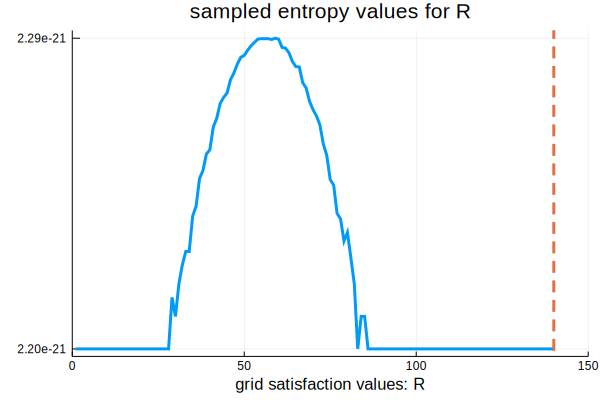

In [16]:
plt2 = plot(1:R_MAX,sampleOmegaR,xlim=(0,R_MAX+10),linewidth=3,title="sampled omega size for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)
savefig(plt2,"figs/sampledOmega.png")



function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end

entropyVals = [S_entropy_values_from_R(R) for R in 1:R_MAX]

println(entropyVals)
println(S_entropy_values_from_R(1),"---",S_entropy_values_from_R(round(Int,R_MAX/2)))

minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt4 = plot(1:R_MAX,entropyVals,
    yticks=([minimum(entropyVals),maximum(entropyVals)],[labelMin,labelMax]),
    xlim=(0,R_MAX+10),ylim=(minimum(entropyVals)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyVals)),
    linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

Any[61, 128, 136, 137, 139, 138, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Any[2.29345e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21]
-8.881632306100267503971362549434243999851031398902534826200420548115384983799799e-23
2.29e-212.20e-21


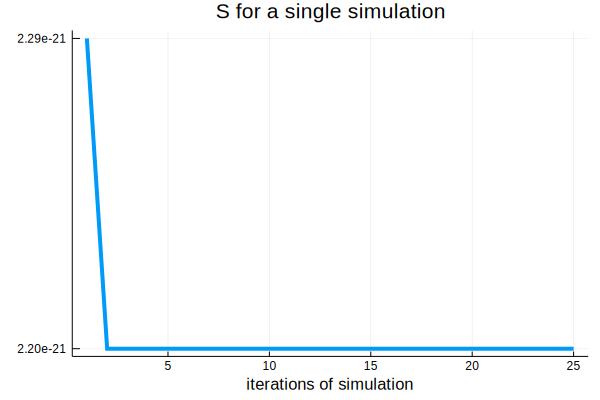

In [17]:
#plt3 = plot(1:R_MAX,entropyVals,xlim=(0,R_MAX+10),linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
#vline!([R_MAX],line=(3,:dash),leg=false)
#savefig(plt3,"figs/sampledEntropy.png"
savefig(plt4,"figs/sampledEntropy.png")


#now do a single run trace with the entropy values and plot
traceR = Int[]
traceS = Int[]

newGrid = shuffle(empty_grid)
traceR = []
traceS = []
Rtmp = grid_satisfaction(newGrid)
append!(traceR,Rtmp)
append!(traceS,S_entropy_values_from_R(Rtmp))
for tt in 2:TT
    newGrid = move_cells_for_satisfaction(newGrid)
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
end
println(traceR)
println(traceS)

println( minimum(traceS) - maximum(traceS)   )


minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(traceS,yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),ylims=(minimum(traceS)*(1-(10^-3)),(1 + 10^-3)*maximum(traceS)),
    linewidth=4,title="S for a single simulation",xlabel="iterations of simulation",leg=false)


In [18]:
savefig(plt5,"figs/entropySingleSimulation.png")



(25, 10)
2.29e-212.20e-21


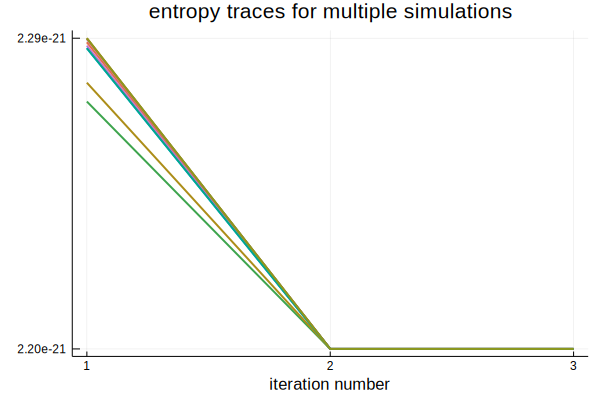

In [19]:


simulationSvals = zeros(TT,MM)
for mm in 1:MM
    traceR = Int[]
    traceS = Int[]

    newGrid = shuffle(empty_grid)
    traceR = []
    traceS = []
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        Rtmp = grid_satisfaction(newGrid)
        append!(traceR,Rtmp)
        append!(traceS,S_entropy_values_from_R(Rtmp))
    end
    simulationSvals[:,mm] = traceS[:]

end

println(size(simulationSvals))
minimumS = minimum(simulationSvals)
maximumS = maximum(simulationSvals)



minStr = string(minimum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(simulationSvals)) )
tmp2 = string(minimum(simulationSvals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(simulationSvals)) )
tmp2 = string(maximum(simulationSvals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt7 = plot(simulationSvals[1:3,1:end],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=2,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


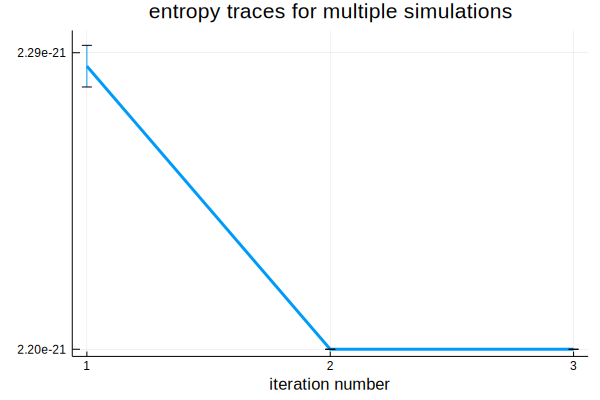

In [20]:
savefig(plt7,"figs/entropyMultipleSimulations.png")


plt8 = plot(mean(simulationSvals,dims=2)[1:3],
    yerr=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 



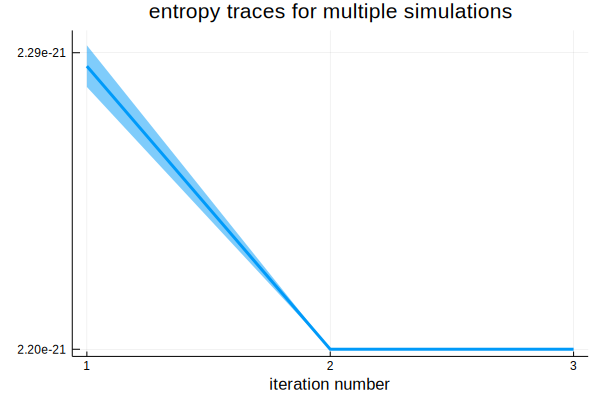

In [21]:
savefig(plt8,"figs/entropyMultipleSimulationsSpread.png")


plt9 = plot(mean(simulationSvals,dims=2)[1:3],
    ribbon=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


In [22]:
savefig(plt9,"figs/entropyMultipleSimulationsSpreadRibbon.png")




In [23]:
##################
#FINANCE PART NOW!
##################


#wealth distribution data taken from: https://raw.githubusercontent.com/jkeesh/which-percent/master/data.csv
# It is based on data from the US census as well as the Social Security Administration
csvWealth = CSV.File("wealthDistribution.csv",header=false)
dfWealth = DataFrame(csvWealth)
percs = dfWealth[:,4]
percsNew=[percs[i][1:end-1] for i in 1:length(percs)]
percsNewNew = [ parse(Float64,percsNew[i]) for i in 1:length(percs)]

#produces the 2 column data for the percentage that has more than a certain amount
function df2wealthArray(dfWealth)
    meansBracket = []
    for i in 1:size(dfWealth)[1]
        
        inds = findall(isequal(' '),dfWealth[i,1])
        
        money1 = dfWealth[i,1][1:inds[1]-1]
        money2 = dfWealth[i,1][inds[2]+1:end]
        
        
        
        if(i == size(dfWealth)[1])
            money2 = money1
        end
        
        money1 = replace(money1,","=>"")
        money2 = replace(money2,","=>"")
        money1 = parse(Float64,money1)
        money2 = parse(Float64,money2)
        
        #println(mean([money1,money2]))
        append!(meansBracket,mean([money1,money2]))
        
    end
    return meansBracket
end
wealthBrackets = df2wealthArray(dfWealth)
percsAndWealth = hcat(percsNewNew,wealthBrackets) 
println(percsAndWealth)
println(percsAndWealth[1,:])


Any[100.0 2500.0; 85.7293 7499.99; 76.9745 12500.0; 69.1804 17500.0; 61.9069 22500.0; 55.0045 27500.0; 48.561 32500.0; 42.5631 37500.0; 37.1403 42500.0; 32.3649 47500.0; 28.2287 52500.0; 24.6107 57500.0; 21.5469 62500.0; 18.891 67500.0; 16.632 72500.0; 14.6756 77500.0; 12.9786 82500.0; 11.5263 87500.0; 10.2775 92500.0; 9.1938 97500.0; 8.254 102500.0; 7.4264 107500.0; 6.7202 112500.0; 6.1026 117500.0; 5.5552 122500.0; 5.0663 127500.0; 4.6402 132500.0; 4.2636 137500.0; 3.9302 142500.0; 3.635 147500.0; 3.3701 152500.0; 3.127 157500.0; 2.915 162500.0; 2.7278 167500.0; 2.5601 172500.0; 2.4087 177500.0; 2.272 182500.0; 2.1452 187500.0; 2.032 192500.0; 1.9275 197500.0; 1.8301 225000.0; 1.1727 275000.0; 0.8155 325000.0; 0.6046 375000.0; 0.4656 425000.0; 0.37 475000.0; 0.3012 750000.0; 0.0825 1.25e6; 0.0411 1.75e6; 0.0258 2.25e6; 0.0182 2.75e6; 0.0138 3.25e6; 0.0108 3.75e6; 0.0087 4.25e6; 0.0072 4.75e6; 0.0061 7.5e6; 0.002 1.5e7; 0.0006 3.5e7; 0.0001 5.0e7]
Any[100.0, 2500.0]


In [24]:
#now sample according to the population a wealth bracket to produce a wealth number from the data

function wealthBracketSample()
    brackets = findall(isequal(true), rand()*100 .<= percsAndWealth[:,1] )
    maxBracketInd = maximum(brackets)
    #println(maxBracketInd)
    return percsAndWealth[maxBracketInd,2]
end

wealthSamples = [wealthBracketSample() for i in 1:10]
println(wealthSamples)


[37500.0, 32500.0, 32500.0, 27500.0, 17500.0, 37500.0, 127500.0, 32500.0, 17500.0, 32500.0]


--yellow mean--37642.857142857145--blue mean--36642.857142857145
std yellow sample 41953.83443265328
std blue sample 34113.74227504631
skewness yellow sample 1.9469300785702395
skewness blue sample 1.2391405206322605


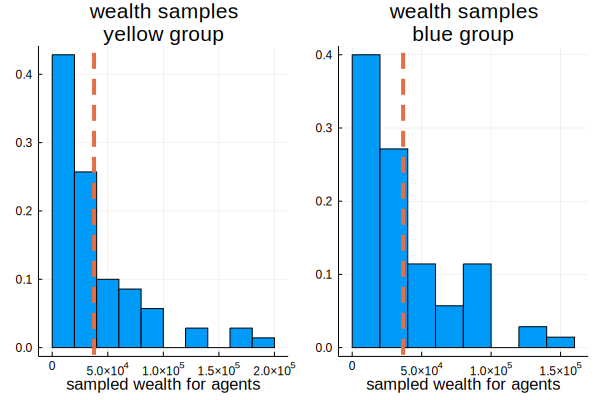

In [25]:

wealthSamplesYellow = [wealthBracketSample() for i in 1:yellow_count]
wealthSamplesYellow = round.(wealthSamplesYellow)
wealthSamplesBlue = [wealthBracketSample() for i in 1:blue_count]
wealthSamplesBlue = round.(wealthSamplesBlue)

println("--yellow mean--",mean(wealthSamplesYellow),"--blue mean--",mean(wealthSamplesBlue))

println("std yellow sample $(std(wealthSamplesYellow))")
println("std blue sample $(std(wealthSamplesBlue))")
println("skewness yellow sample $(skewness(wealthSamplesYellow))")
println("skewness blue sample $(skewness(wealthSamplesBlue))")

pltHistYellow = histogram(wealthSamplesYellow,normalize=:probability,title="wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellow)],line=(4,:dash),leg=false)

pltHistBlue = histogram(wealthSamplesBlue,normalize=:probability,title="wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlue)],line=(4,:dash),leg=false)

plt2hist = plot(pltHistYellow,pltHistBlue)

[2500.0, 37500.0, 22500.0, 12500.0, 42500.0, 62500.0, 2500.0, 17500.0, 42500.0, 2500.0, 2500.0, 82500.0, 12500.0, 22500.0, 32500.0, 82500.0, 52500.0, 32500.0, 27500.0, 32500.0, 7500.0, 132500.0, 17500.0, 22500.0, 27500.0, 27500.0, 2500.0, 82500.0, 7500.0, 17500.0, 22500.0, 22500.0, 62500.0, 2500.0, 22500.0, 72500.0, 57500.0, 167500.0, 57500.0, 32500.0, 137500.0, 2500.0, 12500.0, 2500.0, 52500.0, 32500.0, 67500.0, 187500.0, 77500.0, 17500.0, 17500.0, 12500.0, 2500.0, 177500.0, 22500.0, 7500.0, 7500.0, 7500.0, 12500.0, 32500.0, 2500.0, 7500.0, 62500.0, 82500.0, 42500.0, 22500.0, 12500.0, 2500.0, 7500.0, 12500.0, 72500.0, 27500.0, 27500.0, 67500.0, 12500.0, 22500.0, 7500.0, 82500.0, 27500.0, 37500.0, 22500.0, 92500.0, 92500.0, 2500.0, 32500.0, 82500.0, 57500.0, 12500.0, 2500.0, 47500.0, 42500.0, 17500.0, 27500.0, 32500.0, 2500.0, 2500.0, 17500.0, 82500.0, 12500.0, 12500.0, 27500.0, 7500.0, 47500.0, 22500.0, 37500.0, 47500.0, 147500.0, 17500.0, 17500.0, 47500.0, 32500.0, 82500.0, 32500.0, 

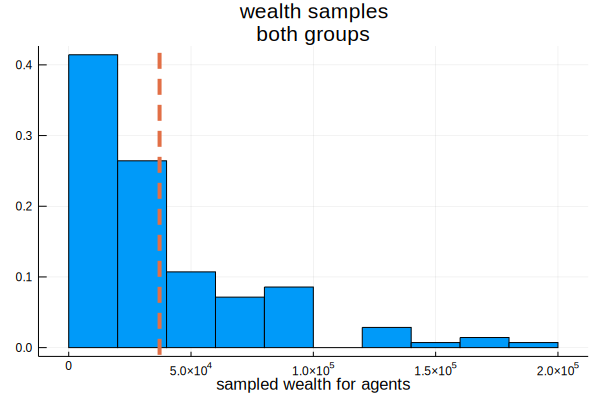

In [26]:

savefig(plt2hist,"figs/histwealthYellow.png")

totalWealthSamples = [wealthSamplesYellow ; wealthSamplesBlue]
println(totalWealthSamples)
println(size(totalWealthSamples))

pltHistTotal = histogram(totalWealthSamples,normalize=:probability,title="wealth samples \n both groups",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(totalWealthSamples)],line=(4,:dash),leg=false)


--yellowNormed mean--0.014285714285714285--blueNormed mean--0.014285714285714284
std yellowNormed sample 0.015921758797970885
std blueNormed sample 0.013299704590661328
skewness yellowNormed sample 1.946930078570239
skewness blueNormed sample 1.2391405206322599


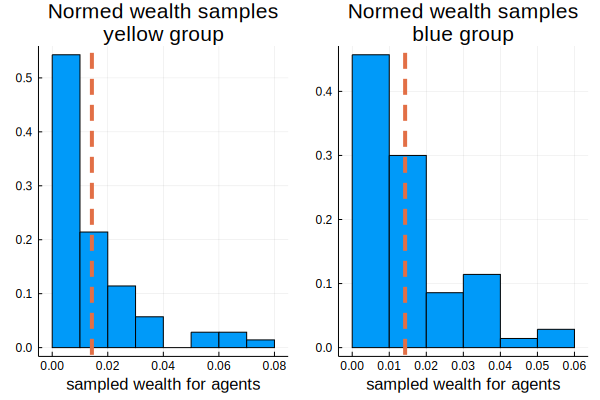

In [27]:

savefig(pltHistTotal,"figs/histwealthTotal.png")

wealthSamplesYellowNormed = wealthSamplesYellow ./ sum(wealthSamplesYellow)
wealthSamplesBlueNormed = wealthSamplesBlue ./ sum(wealthSamplesBlue)

println("--yellowNormed mean--",mean(wealthSamplesYellowNormed),"--blueNormed mean--",mean(wealthSamplesBlueNormed))

println("std yellowNormed sample $(std(wealthSamplesYellowNormed))")
println("std blueNormed sample $(std(wealthSamplesBlueNormed))")
println("skewness yellowNormed sample $(skewness(wealthSamplesYellowNormed))")
println("skewness blueNormed sample $(skewness(wealthSamplesBlueNormed))")

pltHistYellowNormed = histogram(wealthSamplesYellowNormed,normalize=:probability,title="Normed wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellowNormed)],line=(4,:dash),leg=false)

pltHistBlueNormed = histogram(wealthSamplesBlueNormed,normalize=:probability,title="Normed wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlueNormed)],line=(4,:dash),leg=false)

plotNormedHists = plot(pltHistYellowNormed,pltHistBlueNormed)


In [28]:
savefig(plotNormedHists,"figs/histwealthYellow.png")


In [29]:
#in the finance grid we store both the type of agent and the financial part
#sample wealths, non-normed and then norm or not, and set random positions for agent types, apply the 
#normed wealths randomly
function make_random_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    wealthSamplesYellow = [wealthBracketSample() for i in 1:yellow_count]
    wealthSamplesYellow = round.(wealthSamplesYellow)
    wealthSamplesBlue = [wealthBracketSample() for i in 1:blue_count]
    wealthSamplesBlue = round.(wealthSamplesBlue)
    
    
    NORMED = true
    if(NORMED == true)
        samplesYellow = wealthSamplesYellow ./ sum(wealthSamplesYellow)
        samplesBlue = wealthSamplesBlue ./ sum(wealthSamplesBlue)
    else
        samplesYellow = wealthSamplesYellow #./ sum(wealthSamplesYellow)
        samplesBlue = wealthSamplesBlue #./ sum(wealthSamplesBlue)
    end
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= samplesYellow
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= samplesBlue
    
    indShuffle = shuffle(1:GRID_SIZE^2)
    indShuffleShift = indShuffle .+ GRID_SIZE^2
    empty_grid[1:GRID_SIZE^2] = empty_grid[indShuffle]
    empty_grid[1 .+ GRID_SIZE^2 : GRID_SIZE^2 .+ GRID_SIZE^2 ] = empty_grid[indShuffleShift]
    #empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    
    return empty_grid
end
#spatial and financial
moneyGrid = make_random_finance_grid()
println(moneyGrid)
println(sum(moneyGrid))
println(length(findall(moneyGrid[:,:,2] .!= 0)))
b1 = (moneyGrid[:,:,2] .== 0.0)
b2 = (moneyGrid[:,:,1] .== 0.0)
println(count(isequal.(b1,b2)))
println("cool if true...=$(count(isequal.(b1,b2))==GRID_SIZE^2)")

[-1.0 1.0 1.0 1.0 -1.0 1.0 -1.0 -1.0 0.0 -1.0 1.0 1.0 1.0; 0.0 1.0 1.0 1.0 1.0 -1.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0; 0.0 -1.0 -1.0 1.0 0.0 1.0 1.0 1.0 0.0 -1.0 -1.0 -1.0 -1.0; 1.0 -1.0 1.0 -1.0 -1.0 0.0 0.0 1.0 -1.0 1.0 -1.0 -1.0 0.0; -1.0 1.0 -1.0 -1.0 -1.0 1.0 0.0 -1.0 -1.0 0.0 -1.0 1.0 -1.0; -1.0 -1.0 1.0 -1.0 -1.0 -1.0 1.0 1.0 1.0 1.0 0.0 -1.0 1.0; -1.0 -1.0 1.0 1.0 1.0 0.0 0.0 -1.0 1.0 1.0 1.0 -1.0 1.0; 1.0 1.0 1.0 -1.0 -1.0 0.0 0.0 1.0 0.0 1.0 -1.0 -1.0 -1.0; -1.0 1.0 -1.0 -1.0 1.0 0.0 0.0 -1.0 0.0 0.0 -1.0 -1.0 -1.0; 1.0 -1.0 1.0 -1.0 -1.0 1.0 -1.0 1.0 1.0 -1.0 1.0 1.0 -1.0; 0.0 0.0 0.0 1.0 1.0 -1.0 1.0 1.0 0.0 1.0 -1.0 1.0 -1.0; -1.0 1.0 1.0 0.0 1.0 -1.0 -1.0 1.0 1.0 -1.0 0.0 1.0 -1.0; -1.0 -1.0 -1.0 1.0 1.0 0.0 1.0 -1.0 -1.0 -1.0 -1.0 -1.0 1.0]

[0.00420521 0.0023166 0.0023166 0.0301158 0.00756939 0.003861 0.0126156 0.039529 0.0 0.00756939 0.0362934 0.0131274 0.0023166; 0.0 0.0131274 0.027027 0.000772201 0.003861 0.0058873 0.0023166 0.0023166 0.0239382 0.0100386 0.0 0.0 0.00694981

In [30]:
#get the financial surroundings
#pass the grid and provide the cell to get the surrounding finance or type array
function cell_surround_arrayTMP_financial(gridFull,row,col,third)
    grid = gridFull[:,:,third]
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end
arrayCellFinance = cell_surround_arrayTMP_financial(moneyGrid,11,12,2)
println(arrayCellFinance)
arrayCellType = cell_surround_arrayTMP_financial(moneyGrid,11,12,1)
println(arrayCellType)

Any[0.0131274, 0.00694981, 0.0294365, 0.0058873, 0.0176619, 0.0, 0.000772201, 0.00925147]
Any[1.0, 1.0, -1.0, -1.0, -1.0, 0.0, 1.0, -1.0]


In [31]:

#the equivalent of 'thresholdFN' that examines a locality to see financial deviation
#give the full grid, the surrounding array for the finance and return the MAD in this case
function financial_cell_deviation(gridFull,cellSurroundArray,row,col)
    cellFinance = gridFull[row,col,2]
    if(cellFinance == 0)
        return 0
    end
    #println(cellFinance)    
    deviation = mad(cellSurroundArray,center=cellFinance,normalize=false)
    return deviation
    
end

moneyDeviation = financial_cell_deviation(moneyGrid,arrayCellFinance,11,12)
println(moneyDeviation)
println(moneyGrid[11,12,2])


0.007328438615234242
0.0007722007722007722


In [32]:
#find the total deviation for the cells finances
#find all the financial deviations accross all the cells and aggregate
function financial_grid_deviation(gridFull)
    #grid = gridFull[:,:,2]
    cell_deviation = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            arrayCellFinance = cell_surround_arrayTMP_financial(gridFull,row,col,2)
            #t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            moneyDeviation = financial_cell_deviation(gridFull,arrayCellFinance,row,col)
            #tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_deviation,moneyDeviation)
        end
    end    
    return sum(cell_deviation)    
    
end
gridDeviationMedians = financial_grid_deviation(moneyGrid);
println(gridDeviationMedians)
println("yay")
 
x = [financial_grid_deviation(make_random_finance_grid()) for i in 1:100]
println(mean(x))
println("min MAD of financial deviations of full grids=",minimum(x))
println("max MAD of financial deviations of full grids=",maximum(x))

1.89524080129631
yay
1.8127783681929102
min MAD of financial deviations of full grids=1.599683198000218
max MAD of financial deviations of full grids=1.9890952407936202


mean of the deviations for the sampled= 1.8113708005546705


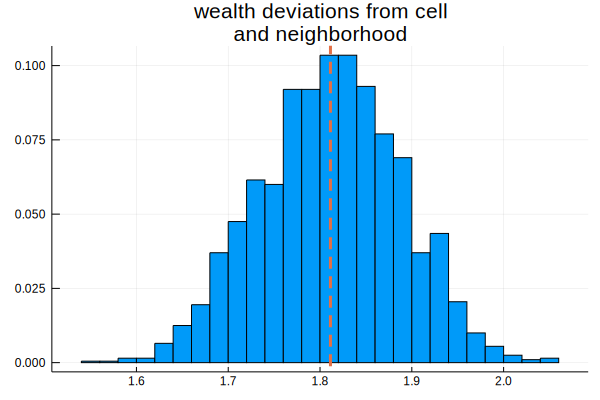

In [33]:
#try running the random deviations over a set to see the distribution
numberOfRandomSamples = 2000
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviations = mean(randomMoneyDeviations)

println("mean of the deviations for the sampled= $(mean(randomMoneyDeviations))")
pltHist = histogram(randomMoneyDeviations,leg=false,normalize=:probability,
    title="wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)



[0.398301, 0.548065, 0.232546, 0.657104, 0.749859, 0.656677, 0.0464128, 0.71203, 0.809713, 0.642818]
[0.00116757, 0.0220141, 0.00681645, 0.0198271, 0.0178563, 0.0184665, 0.000647575, 0.0198709, 0.0114278, 0.0205182, 0.0194325, 0.0197174, 0.000967066, 0.0145768, 0.00767477, 0.0226815, 0.0116881, 0.01225, 0.0057827, 0.0238371, 0.00459846, 0.0119009, 0.0176524, 0.0167344, 0.0221003, 0.0229233, 0.0116877, 0.0227041, 0.0196405, 0.000713637, 0.00332367, 0.0204521, 0.00808198, 0.0126234, 0.0207868, 0.00627048, 0.0190086, 0.0244213, 0.00616362, 0.0238848, 0.00487301, 0.0121052, 0.019872, 0.013678, 0.0101932, 0.0221271, 0.0150064, 0.0134484, 0.00495236, 0.021246, 0.0249076, 0.0198429, 0.0209059, 0.00645177, 0.0199959, 0.00309443, 0.0244669, 0.0173944, 0.00494749, 0.0174252, 0.0240755, 0.0119394, 0.00718273, 0.00267733, 0.0140253, 0.0184749, 0.0230869, 0.00532781, 0.0203674, 0.00301605]
2.0000000000000053
mean of the deviations for he uniform sampled= 1.4851501017403306


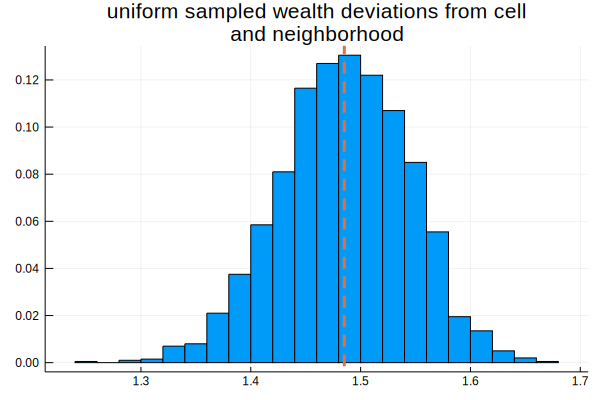

In [34]:
savefig(pltHist,"figs/histwealthSampleDeviations.png")

function randUniformWealthBracketSample()
    #row = Int(round(rand() * size(percsAndWealth)[1]))
    return rand()
end

wealthSamples = [randUniformWealthBracketSample() for i in 1:10]
println(wealthSamples)


#in the finance grid we store both the type of agent and the financial part
yellowUniformSample = [randUniformWealthBracketSample() for i in 1:yellow_count]
blueUniformSample = [randUniformWealthBracketSample() for i in 1:blue_count]

NORMED = true

if(NORMED == true)
    wealthSamplesYellowUniformSampled = yellowUniformSample ./ sum(yellowUniformSample)
    wealthSamplesBlueUniformSampled = blueUniformSample ./ sum(blueUniformSample)
    println(wealthSamplesBlueUniformSampled)
else
    wealthSamplesYellowUniformSampled = yellowUniformSample #./ sum(yellowUniformSample)
    wealthSamplesBlueUniformSampled = blueUniformSample# ./ sum(blueUniformSample)
end

    
function make_uniform_sampled_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= wealthSamplesYellowUniformSampled
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= wealthSamplesBlueUniformSampled
    
    empty_grid[:,:,1] = shuffle(empty_grid[:,:,1])
    empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    return empty_grid
end

moneyGridUniformSampled = make_uniform_sampled_finance_grid()
println(sum(moneyGridUniformSampled))


randomUniformMoneyDeviations = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealUniformMoneyDeviations = mean(randomUniformMoneyDeviations)

println("mean of the deviations for he uniform sampled= $(mean(randomUniformMoneyDeviations))")
pltHistUniform = histogram(randomUniformMoneyDeviations,leg=false,normalize=:probability,title="uniform sampled wealth deviations from cell\n and neighborhood")
vline!([mean(randomUniformMoneyDeviations)],line=(3,:dash),leg=false)


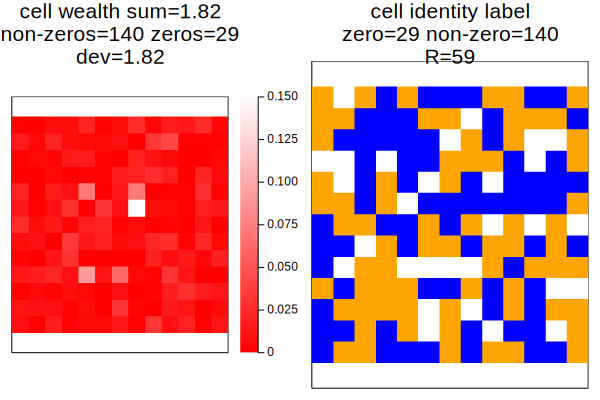

1


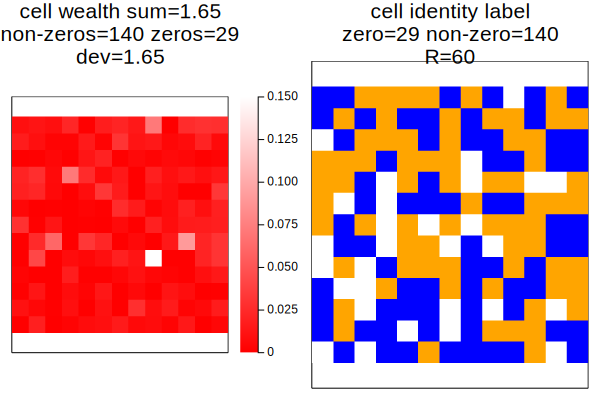

2


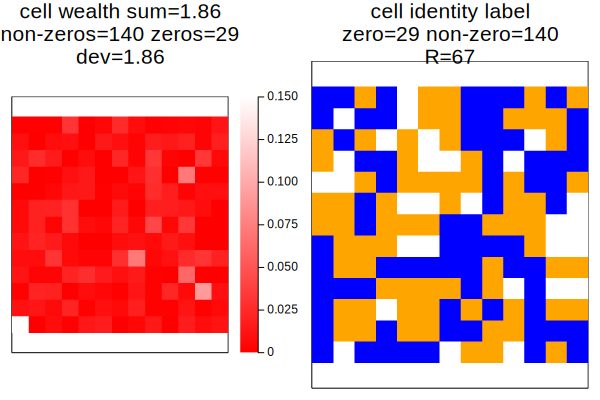

3


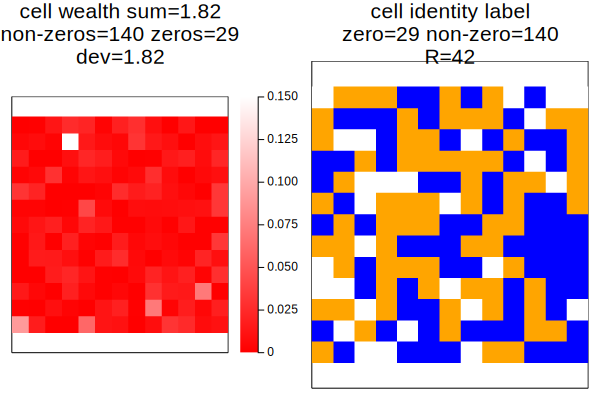

4


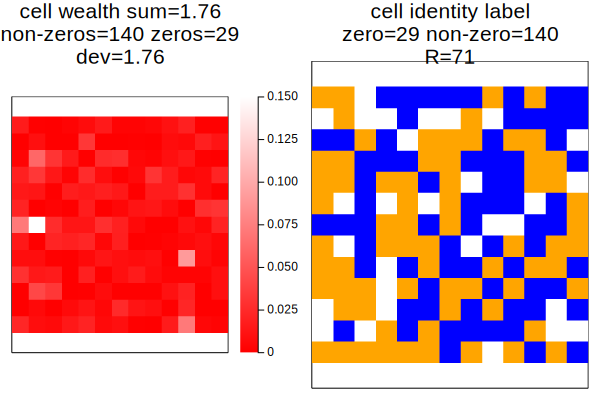

5


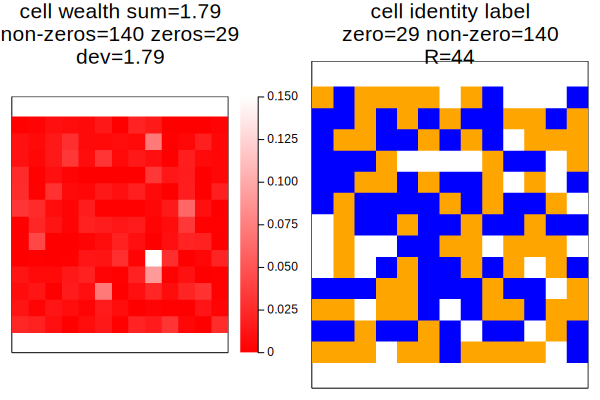

6


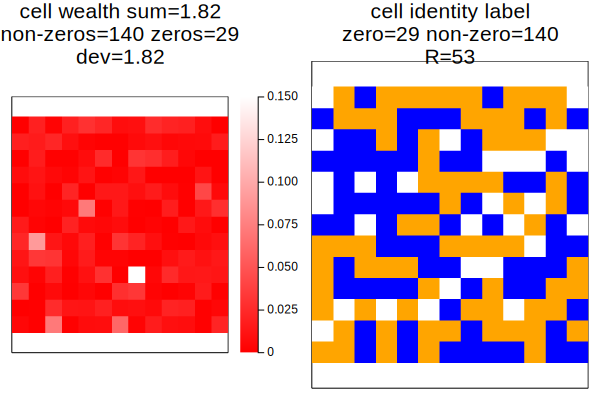

7


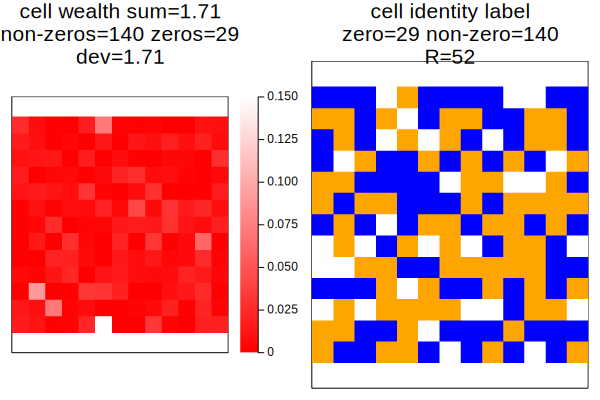

8


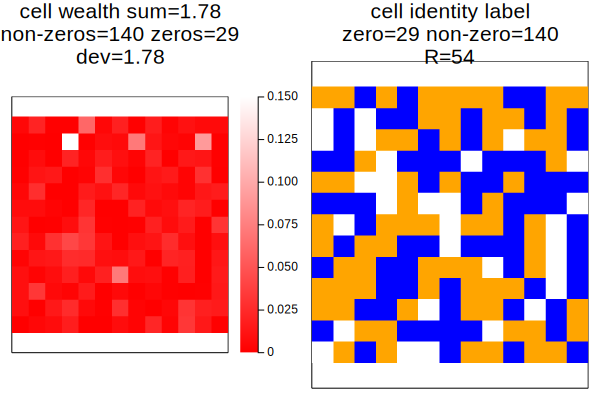

9


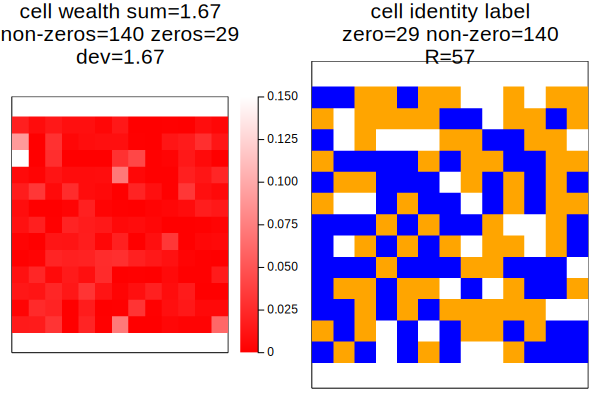

10


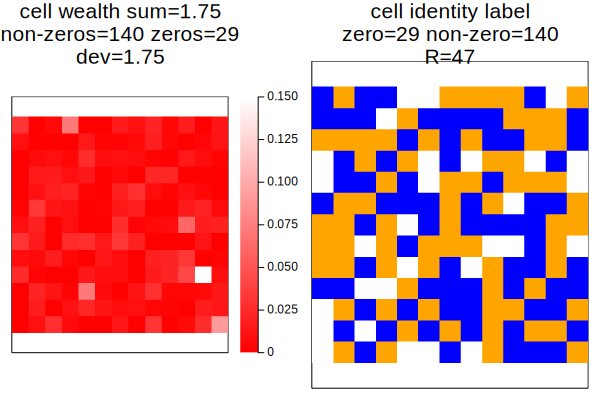

11


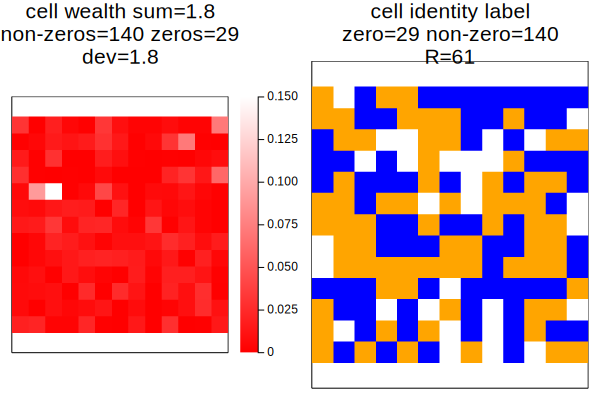

12


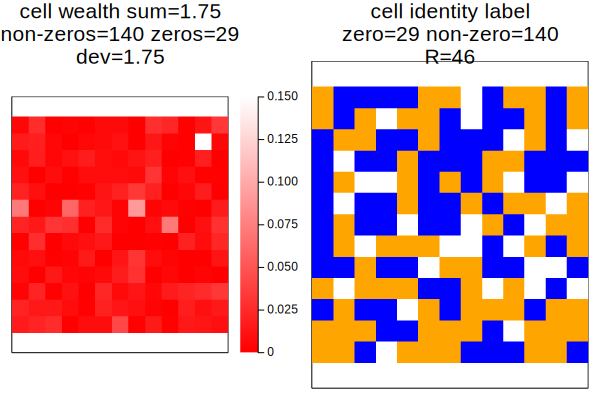

13


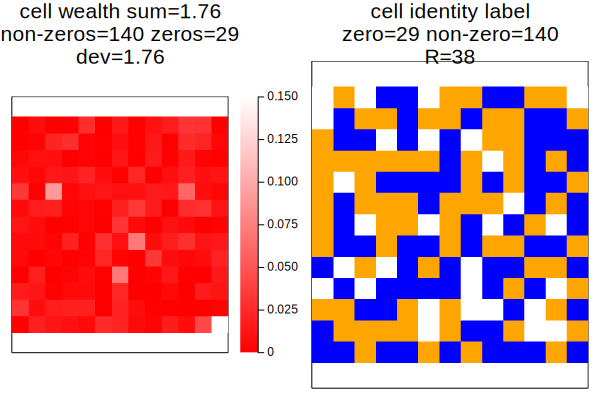

14


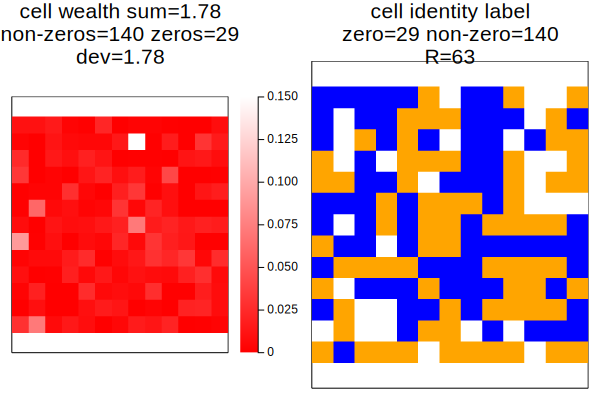

15


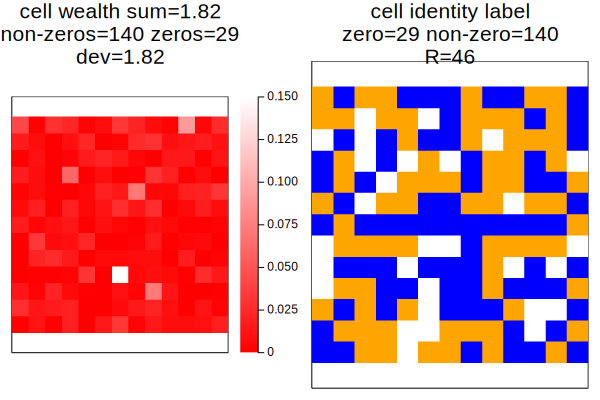

16


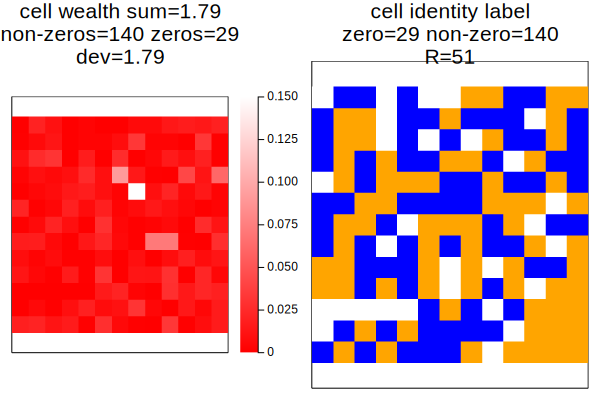

17


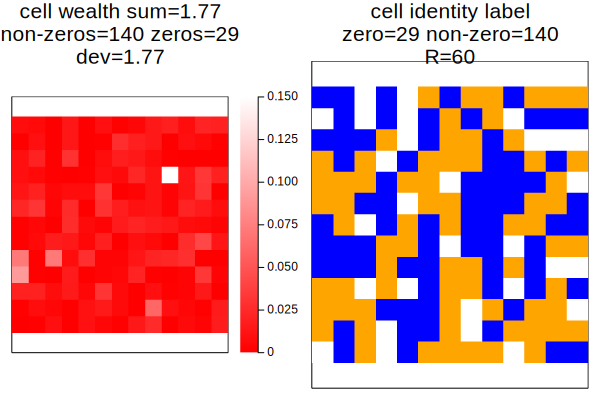

18


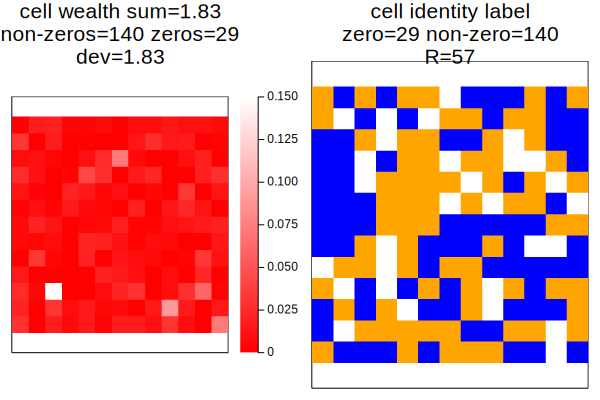

19


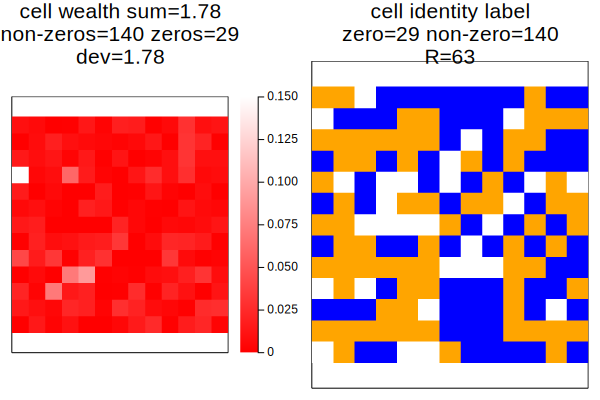

20


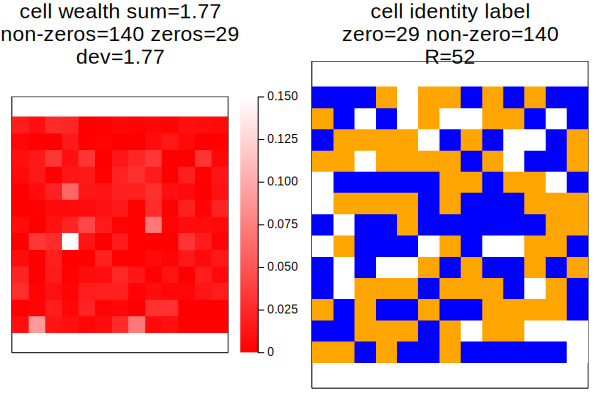

21


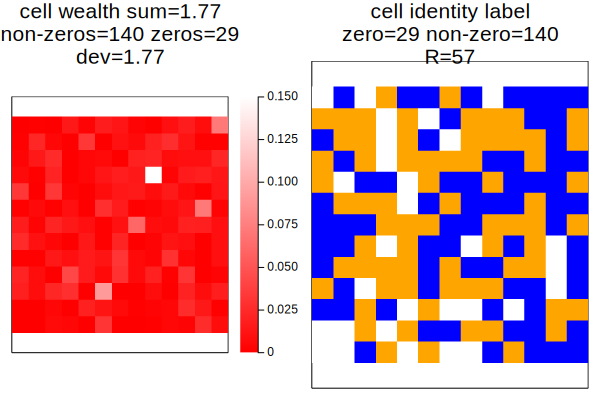

22


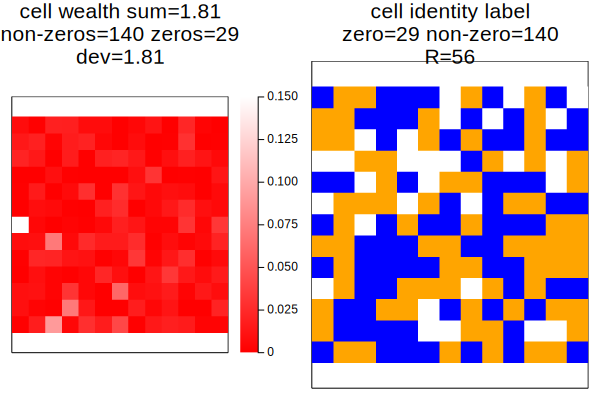

23


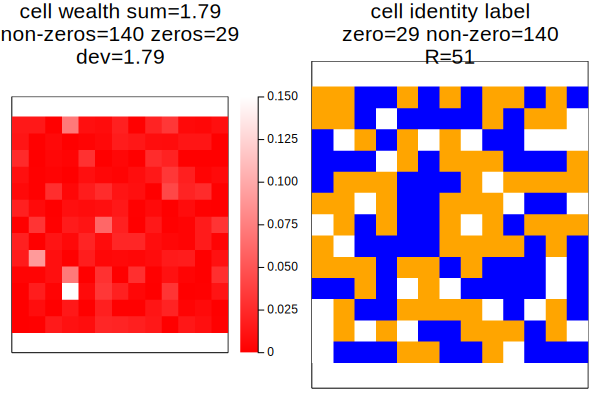

24


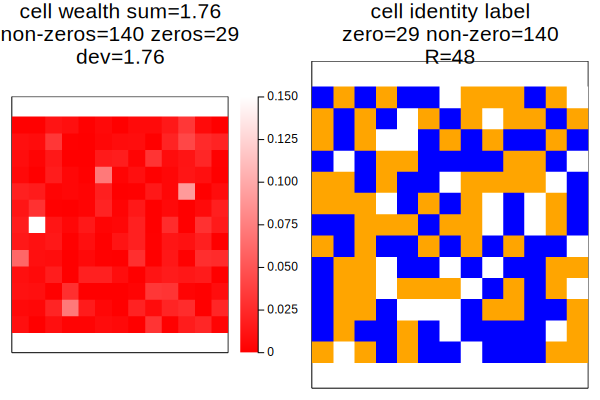

25
---produce random financial grids and then financial grids no movements to see hopefully no differences
x=1.8366783764508807
x2=1.7981712915170676


In [35]:
savefig(pltHistUniform,"figs/histwealthUniformSampleDeviations.png")


#wealth no dynamics just moves the cells around randomly and continuously and at each iteration check the 
#financial cell deviation at each iteration, and at each move ...
##<pick a random percentage of the wealth and radiate that amongst the neighbors
function move_cells_for_wealth_NoDynamics(grid)
    
    #grid = deepcopy(gridOrig) 
    
    nonZeroCells = findall(grid[:,:,1] .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
        
    
    for nzc in nonZeroCells2 
        emptyCells = findall(grid[:,:,1] .== 0)
        emptyCells2 = shuffle(emptyCells)
        ec = emptyCells2[1]
        grid[ec[1],ec[2],1] = grid[nzc[1],nzc[2],1]
        grid[nzc[1],nzc[2],1] = 0             
           
        grid[ec[1],ec[2],2] = grid[nzc[1],nzc[2],2]
        grid[nzc[1],nzc[2],2] = 0 
        #radiate the finance randomly on the surroundings
        #grid = cell_surround_radiate_financialRandomUniform!(grid,ec[1],ec[2])
        
            
    end          
    #println(g2[:,:,1] == newGrid2[:,:,1])
    return grid
end

traceR = zeros(TT)
traceWD = zeros(TT)
 
for tt in 1:TT   
    println(tt)
    if(tt==1)
        moneyGrid = make_random_finance_grid()  
    else
        moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
    end
    
        
    traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
    traceWD[tt] = financial_grid_deviation(moneyGrid)
    wdevTmp = financial_grid_deviation(moneyGrid)
    Rtmp = grid_satisfaction(moneyGrid[:,:,1])
    tmp = round(sum(wdevTmp),digits=2)
    tmp2 = length(findall(moneyGrid[:,:,1] .!= 0))
    tmp2b = length(findall(moneyGrid[:,:,1] .== 0))
    tmp3 = length(findall(moneyGrid[:,:,2] .== 0))
    tmp4 = length(findall(moneyGrid[:,:,2] .!= 0))
    
    hm = heatmap(moneyGrid[:,:,2],title="cell wealth sum=$(tmp) \n non-zeros=$(tmp4) zeros=$(tmp3) \n dev=$(round(wdevTmp,digits=2))",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
    c=ColorGradient([:red,:white]))
    hm2 = heatmap(moneyGrid[:,:,1],title="cell identity label \n zero=$(tmp2b) non-zero=$(tmp2) \n R=$(Rtmp)",
        showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
        c=ColorGradient([:orange,:white,:blue]))

    p1=plot(hm,hm2)
    display(p1)
    savefig(hm,"figs/simulationSnapShots2/time$(tt).png")
end

println("---produce random financial grids and then financial grids no movements to see hopefully no differences")
x = mean([financial_grid_deviation(make_random_finance_grid()) for i in 1:10])
println("x=$(x)")
x2 = mean([financial_grid_deviation(move_cells_for_wealth_NoDynamics(make_random_finance_grid())) for i in 1:10])
println("x2=$(x2)")

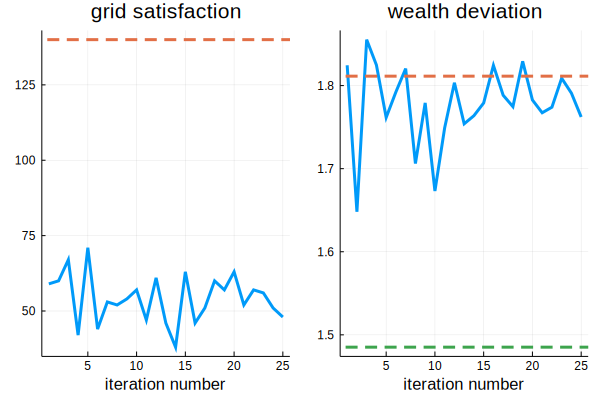

In [36]:


p1 = plot(traceR,linewidth=3,title="grid satisfaction",xlabel="iteration number")
hline!([R_MAX],line=(3,:dash),leg=false)
p2 = plot(traceWD,linewidth=3,title="wealth deviation",xlabel="iteration number")
hline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)
hline!([mean(randomUniformMoneyDeviations)],line=(3,:dash),leg=false)
pboth = plot(p1,p2)
display(pboth)
savefig(pboth,"figs/RandWealthDevRandomNoDynamics.png")



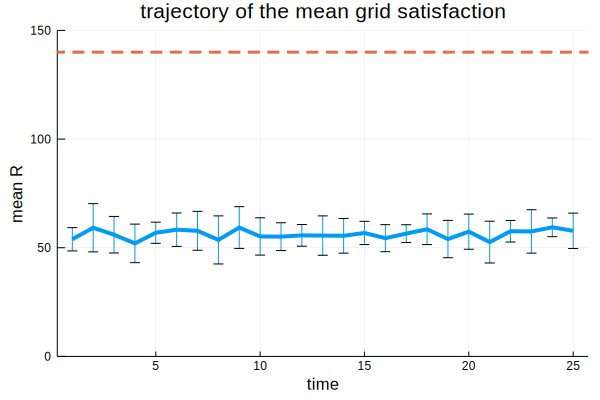

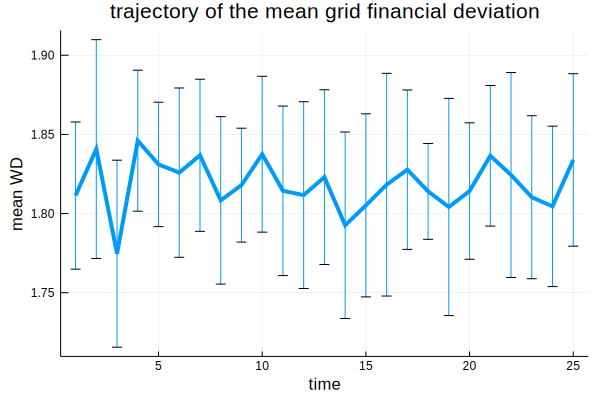

In [37]:


simulationRvals = zeros(TT,MM)
simulationWvals = zeros(TT,MM)
for mm in 1:MM    
    
    traceR = zeros(TT)
    traceWD = zeros(TT)
    for tt in 1:TT   
        #println(tt)
        if(tt==1)
            moneyGrid = make_random_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_NoDynamics(moneyGrid) #make_random_finance_grid()  
        end    

        traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceWD[tt] = financial_grid_deviation(moneyGrid)        

    end

    simulationRvals[:,mm] = traceR[:]
    simulationWvals[:,mm] = traceWD[:]
end
    


 

plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)
display(plt)
savefig(plt,"figs/trajectoryMeanGridSatisfactionWithWealth.png")

plt = plot(mean(simulationWvals,dims=2),xlabel="time",ylabel="mean WD",yerr=std(simulationWvals,dims=2),linewidth=4,title="trajectory of the mean grid financial deviation",leg=false) 
#hline!([R_MAX],line=(3,:dash),leg=false)
display(plt)

savefig(plt,"figs/meanTrajFinancialDeviation.png")

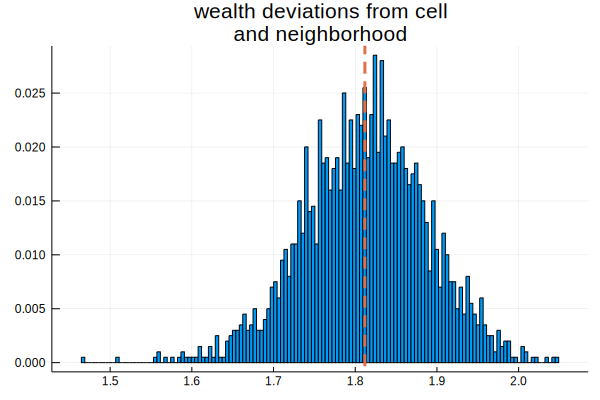

mean of the deviations for the sampled= 1.8118093216949542


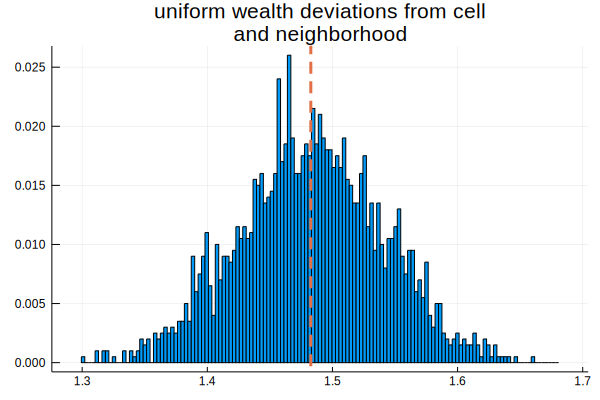

mean of the uniform deviations for the sampled= 1.4827120396595919


In [38]:
#R_MAX
#now compute the sampled distribution for the probability of the different bins
numberOfRandomSamples = 2000
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviations = mean(randomMoneyDeviations)

println("mean of the deviations for the sampled= $(mean(randomMoneyDeviations))")
pltHist = histogram(randomMoneyDeviations,leg=false,normalize=:probability,
    bins=range(minimum(randomMoneyDeviations),stop = maximum(randomMoneyDeviations),length=R_MAX),
    title="wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)
display(pltHist)
savefig(pltHist,"figs/RawWealthDeviationsSample.png")

#randUniformWealthBracketSample()    make_uniform_sampled_finance_grid()

randomMoneyDeviationsUG = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviationsUG = mean(randomMoneyDeviationsUG)
println("mean of the uniform deviations for the sampled= $(mean(randomMoneyDeviationsUG))")
pltHist = histogram(randomMoneyDeviationsUG,leg=false,normalize=:probability,
    bins=range(minimum(randomMoneyDeviationsUG),stop = maximum(randomMoneyDeviationsUG),length=R_MAX),
    title="uniform wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviationsUG)],line=(3,:dash),leg=false)
display(pltHist)
savefig(pltHist,"figs/RawWealthDeviationsSampleUG.png")




In [39]:
#randUniformWealthBracketSample()    make_uniform_sampled_finance_grid()  make_random_finance_grid()
#randomMoneyDeviationsUG = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]

#MACROSTATE SEPARATOR parameter manually fixed as a bin size
SEPBIN = 0.01
roundDigits = 2
maxValExtension = 1.75

#now sample deviations for the probability distribution to be produced for the entropy later
randomMoneyDeviations = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
randomMoneyDeviations = round.(randomMoneyDeviations,digits=roundDigits)
#set the maximum macrostate counts to be 
maxDev = round(maxValExtension * maximum(randomMoneyDeviations),digits=roundDigits)
#rintln(maxDev)
moneyDeviationBins = collect(range(0,step=SEPBIN,stop=maxDev))
#println("moneyDeviationBins=",moneyDeviationBins)
#println("size of the moneyDeviationBins=",length(moneyDeviationBins))
#println(randomMoneyDeviations)
binsDevCounts = [length( findall( dev .== randomMoneyDeviations ) ) for dev in moneyDeviationBins]
replace!(binsDevCounts,0=>1)
binsDevCountsProb = binsDevCounts ./ sum(binsDevCounts)
#println("binsDevCountsProb=",binsDevCountsProb)
#println("size of the moneyDeviationBins=",length(binsDevCountsProb))
binsDev = collect( 0:SEPBIN:length(moneyDeviationBins) .* SEPBIN )

binsAndProbsMoney = hcat(moneyDeviationBins,binsDevCountsProb)
#println("binAndProbsMoney=",binsAndProbsMoney)

#DICT FOR THE WEALTH STATE PROB
dictBinsWealthDevProb = Dict(zip(binsDev,binsDevCountsProb));

#println(dictBinsWealthDevProb)
#println(dictBinsWealthDevProb[1.8])

#DICT FOR THE SAMPLE SPACE
sampleOmegaWD = binsDevCountsProb .* CELLS_SPACE_SIZE
#println(sampleOmegaW)
dictBinsWealthDevOmegaW = Dict(zip(binsDev,sampleOmegaWD));

#println(dictBinsWealthDevOmegaB)
#println(dictBinsWealthDevOmegaB[1.8])
#println(dictBinsWealthDevOmegaB[1.1])


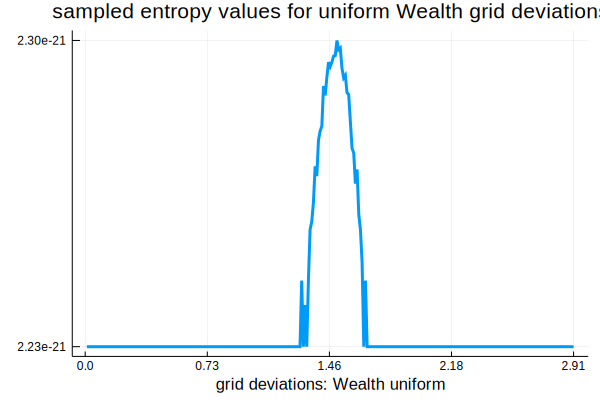

291
2.30e-212.23e-21


In [324]:

function S_entropy_values_from_WD(W)
    return k_b * log(sampleOmegaWD[W])
       
end

entropyValsW = [S_entropy_values_from_WD(W) for W in 1:length(moneyDeviationBins)]
println(length(entropyValsW))
#println((entropyValsW))

minStr = string(minimum(entropyValsW))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyValsW)) )
tmp2 = string(minimum(entropyValsW))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyValsW))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyValsW)) )
tmp2 = string(maximum(entropyValsW))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

strTmp0 = string(0*SEPBIN)
tmp0 = 0
strTmp1 = string(round( length(moneyDeviationBins)* 1/4  * SEPBIN,digits=2))
tmp1 = round( length(moneyDeviationBins)* 1/4,digits=2 )
strTmp2 = string(round( length(moneyDeviationBins)* 2/4  * SEPBIN,digits=2))
tmp2 = round( length(moneyDeviationBins)* 2/4,digits=2 ) 
strTmp3 = string(round( length(moneyDeviationBins)* 3/4  * SEPBIN,digits=2))
tmp3 = round( length(moneyDeviationBins)* 3/4,digits=2 )
strTmp4 = string(length(moneyDeviationBins)*SEPBIN)
tmp4 = length(moneyDeviationBins)

pltSW = plot(1:length(moneyDeviationBins),entropyValsW,
    yticks=([minimum(entropyValsW),maximum(entropyValsW)],[labelMin,labelMax]),
    xticks=([0 tmp1 tmp2 tmp3 tmp4],
        [strTmp0 strTmp1 strTmp2 strTmp3 strTmp4]),
    ylim=(minimum(entropyValsW)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyValsW)),
    linewidth=3,title="sampled entropy values for uniform Wealth grid deviations",xlabel="grid deviations: Wealth uniform",
    leg=false)

display(pltSW)
savefig(pltSW,"figs/entropyWdistribution.png")


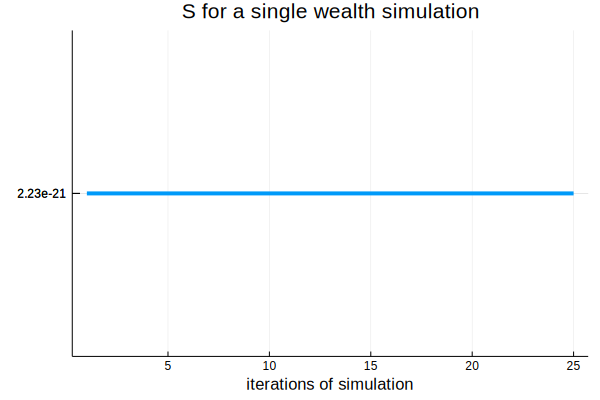

BigFloat[2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21, 2.23089e-21]
2.23e-212.23e-21


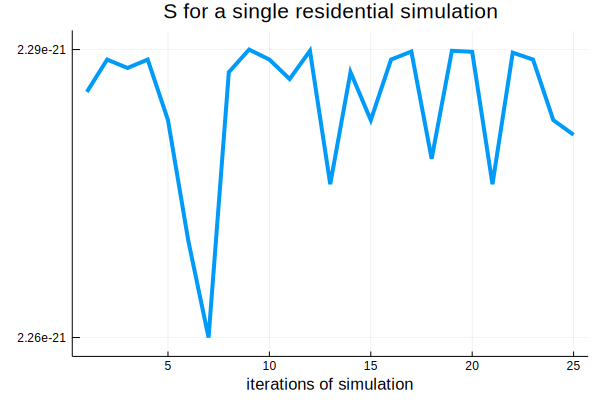

2.29e-212.26e-21


In [73]:
#entropyValsW hold the values of the bins of the accuracy of increments in steps of SEPBIN
#So for the trajectory of the wealth produce an entropy trace

#println(traceWD)

traceWDrnd = round.(traceWD,digits=2)
indsEntropy = map(x->findfirst(x .== binsDev),traceWDrnd)
entropyTraceW = entropyValsW[indsEntropy]


println(entropyTraceW)

function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end

minStr = string(minimum(entropyTraceW))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyTraceW)) )
tmp2 = string(minimum(entropyTraceW))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyTraceW))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyTraceW)) )
tmp2 = string(maximum(entropyTraceW))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(entropyTraceW,
    yticks=([minimum(entropyTraceW),maximum(entropyTraceW)],[labelMin,labelMax]),
    ylims=(minimum(entropyTraceW)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyTraceW)),
    linewidth=4,title="S for a single wealth simulation",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/entropyWsingleTrace.png")

#now for the residential entropy trace
traceSv = [ S_entropy_values_from_R(Int(rr)) for rr in traceR]

minStr = string(minimum(traceSv))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(traceSv)) )
tmp2 = string(minimum(traceSv))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(traceSv))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(traceSv)) )
tmp2 = string(maximum(traceSv))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(traceSv,
    yticks=([minimum(traceSv),maximum(traceSv)],[labelMin,labelMax]),
    ylims=(minimum(traceSv)*(1-(10^-3)),(1 + 10^-3)*maximum(traceSv)),
    linewidth=4,title="S for a single residential simulation",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/entropyRsingleTrace.png")

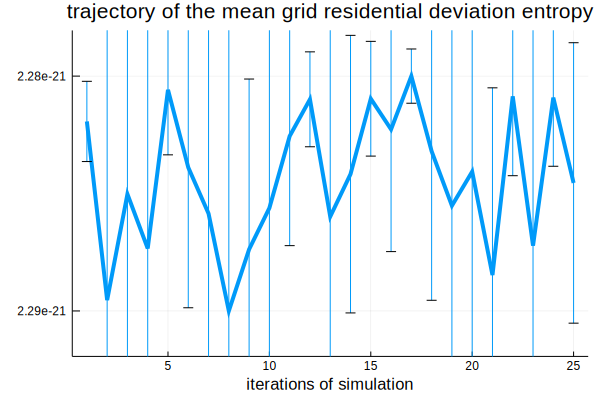

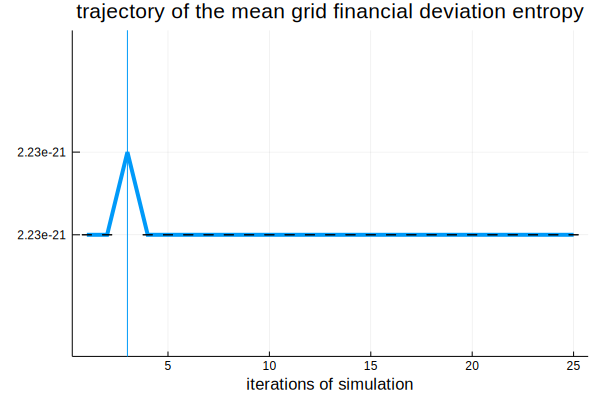

In [84]:
#now the wealth and spatial deviations from a batch simulation

simulationRvalsEntropy = zeros(TT,MM)
simulationWvalsEntropy = zeros(TT,MM)

function entropyTraceWDhelper(wdArray)
    traceWDrnd = round.(wdArray,digits=2)
    indsEntropy = map(x->findfirst(x .== binsDev),traceWDrnd)
    entropyTraceW = entropyValsW[indsEntropy]
    return entropyTraceW
end

function labelMaxMinEntropy(trace)
    minStr = string(minimum(trace))[1:4] 
    tmp = findfirst( isequal('e') , string(minimum(trace)) )
    tmp2 = string(minimum(trace))[tmp:end]
    labelMin = string(minStr,tmp2)
    maxStr = string(maximum(trace))[1:4] 
    tmp = findfirst( isequal('e') , string(maximum(trace)) )
    tmp2 = string(maximum(trace))[tmp:end]
    labelMax = string(maxStr,tmp2)
    return labelMax,labelMin
end

for i in 1:TT
    for j in 1:MM       
        simulationRvalsEntropy[i,j] = S_entropy_values_from_R(Int(simulationRvals[i,j] ))
        simulationWvalsEntropy[i,j] = entropyTraceWDhelper(simulationWvals[i,j])
    end
end



tmp = labelMaxMinEntropy(mean(simulationRvalsEntropy,dims=2))
labelMin,labelMax = tmp[1],tmp[2]
plt5 = plot(mean(simulationRvalsEntropy,dims=2),
    yticks=([minimum(mean(simulationRvalsEntropy,dims=2)),maximum(mean(simulationRvalsEntropy,dims=2))],
        [labelMin,labelMax]),yerr=std(simulationRvalsEntropy,dims=2),
    ylims=(minimum(mean(simulationRvalsEntropy,dims=2))*(1-(10^-3)),(1 + 10^-3)*maximum(mean(simulationRvalsEntropy,dims=2))),
    linewidth=4,title="trajectory of the mean grid residential deviation entropy",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/trajectoryMeanGridSatisfactionResidencyEntropy.png")

tmp = labelMaxMinEntropy(mean(simulationWvalsEntropy,dims=2))
labelMin,labelMax = tmp[1],tmp[2]
plt5 = plot(mean(simulationWvalsEntropy,dims=2),
    yticks=([minimum(mean(simulationWvalsEntropy,dims=2)),maximum(mean(simulationWvalsEntropy,dims=2))],
        [labelMin,labelMax]),yerr=std(simulationWvalsEntropy,dims=2),
        ylims=(minimum(mean(simulationWvalsEntropy,dims=2))*(1-(10^-3)),(1 + 10^-3)*maximum(mean(simulationWvalsEntropy,dims=2))),
    linewidth=4,title="trajectory of the mean grid financial deviation entropy",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/meanTrajFinancialDeviationEntropy.png")

In [ ]:
#------------------------Financial Dynamics Now---------------------#
#------------------------Random moves with Financial 'Spending'-----#

In [158]:
#now there is the residential and the wealth entropy traces up to this point!
#from this point onwards... what needs to be done?
#Change the residential and wealth dynamics to now have the simulation components of expected changes

#has the non-uniform wealth samples so that the radiation makes it more uniform
moneyGrid2 = make_random_finance_grid()
#println(moneyGrid2)
tmp = cell_surround_arrayTMP_financial(moneyGrid2,1,2,2)
println(tmp)
tmp = cell_surround_arrayTMP_financial(moneyGrid2,1,2,1)
println(tmp)
println(sum(abs.(tmp)))

Any[0.00110375, 0.0193843, 0.0165563, 0.0143488, 0.00798176]
Any[1.0, -1.0, 1.0, 1.0, -1.0]
5.0


In [222]:
#get the cell surroundings
#pass the grid and provide the cell to get the surrounding finance or resident type array
#println(moneyGrid2)
moneyGrid2 = make_random_finance_grid()
function cell_surround_array_grid(gridFull,row,col,third)
    grid = gridFull[:,:,third]
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end
        end
    end
    return cell_surrounding
end
#=cell_surrounding = cell_surround_array_grid(moneyGrid2,11,11,1)   
println(cell_surrounding)
neighborNum = Int(sum(abs.(cell_surrounding)))
println(neighborNum)=#

cell_surround_array_grid (generic function with 1 method)

In [223]:
#pass the grid and provide the cell and the array of finance to increment/update the array
#does not update the center cell!
moneyGrid2 = make_random_finance_grid()
function cell_surround_array_financial_Update(gridFull,row,col,third,incrementAr)    
    ind = 1
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if( abs(gridFull[row-1+(ii),(col-1)+(jj),1]) == 1)
                    gridFull[row-1+(ii),(col-1)+(jj),third] += incrementAr[ind]
                    ind += 1
                end
            end
        end
    end    
end
#=
for i in 1:13,j in 1:13
    total = Int(sum(abs.(cell_surround_array_grid(moneyGrid2,i,j,1) )))
    disp = Int.(round.(rand(total) .* 10 .+ 1) )
    tmp = cell_surround_array_financial_Update(moneyGrid2,i,j,2,disp)
    println(disp)
end
=#

cell_surround_array_financial_Update (generic function with 1 method)

In [224]:
#update the wealth of the cell surroundings
#RESIDENTIAL REDISTRIBUTION DYNAMICS!!!

function cell_surround_radiate_financialRandomUniform(grid,row,col)
    if( grid[row,col,1] == 0 )
        return
    end
    newWealth = rand() * grid[row,col,2] #take a random percentage off the wealth
    radiate = grid[row,col,2] - newWealth #how much is spent on the surroundings
    
    cell_surrounding = cell_surround_array_grid(grid,row,col,1)    
    neighborNum = Int(sum(abs.(cell_surrounding)))
    #println(neighborNum)
    
    #!!!KEY TO THE DYNAMICS!!! THIS IS EFFECTIVELY THE REDISTRIBUTION MODEL!!!!<<<<
    rTmp = rand(neighborNum)
    rTmpNorm = rTmp ./ sum(rTmp)
    radiateDist = radiate .* rTmpNorm       
    
    cell_surround_array_financial_Update(grid,row,col,2,radiateDist)
    
    grid[row,col,2] = newWealth 
    return grid
end
#cell_surround_radiate_financialRandomUniform(moneyGrid2,1,1)
#println(moneyGrid2[1:4,1:4,2])

cell_surround_radiate_financialRandomUniform (generic function with 1 method)

In [231]:
#now there is the grid and there has to be moves and wealth dynamics to show the model changes to 
#the entropy regarding the wealth only
#MOVEMENT NO SHELLING, ONLY WEALTH RADIATION
moneyGrid2 = make_random_finance_grid()

function move_cells_for_wealth_Dynamics1(grid)
    #grid = deepcopy(gridOrig)     
    nonZeroCells = findall(grid[:,:,1] .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)            
    for nzc in nonZeroCells2 
        emptyCells = findall(grid[:,:,1] .== 0)
        emptyCells2 = shuffle(emptyCells)
        ec = emptyCells2[1]
       
        grid[ec[1],ec[2],1] = grid[nzc[1],nzc[2],1]
        grid[nzc[1],nzc[2],1] = 0             
           
        grid[ec[1],ec[2],2] = grid[nzc[1],nzc[2],2]
        grid[nzc[1],nzc[2],2] = 0 
        
        #RADIATE THE FINANCE randomly on the surroundings of the 'ec' which was empty but now nzc (nonzero)
                
        cell_surround_radiate_financialRandomUniform(grid,ec[1],ec[2]) 
                
    end          
    #println(g2[:,:,1] == newGrid2[:,:,1])
    return grid
end
move_cells_for_wealth_Dynamics1(moneyGrid2)
println(sum(moneyGrid2))

2.0000000000000027


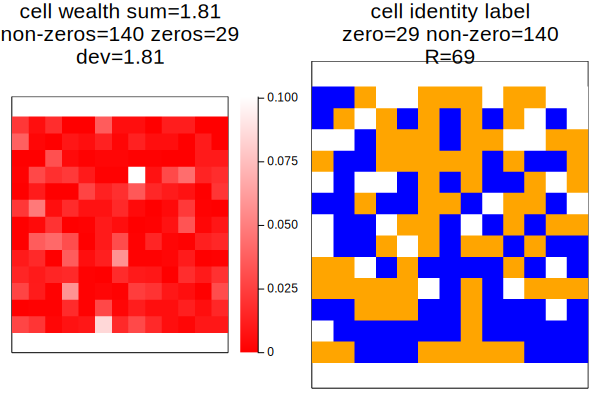

1
1.9999999999999998


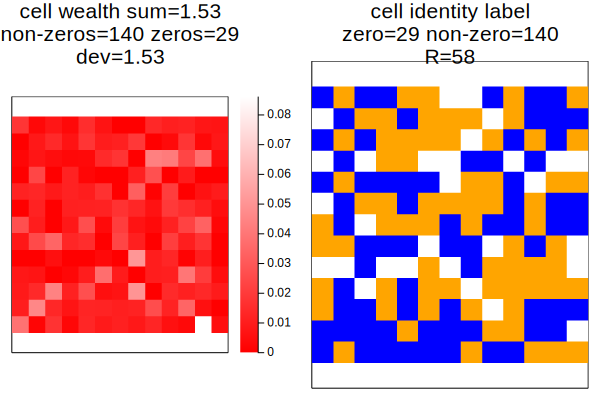

2
2.0
3

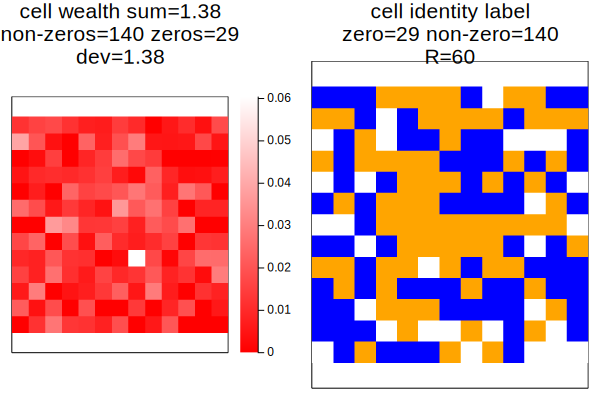


1.9999999999999998
4

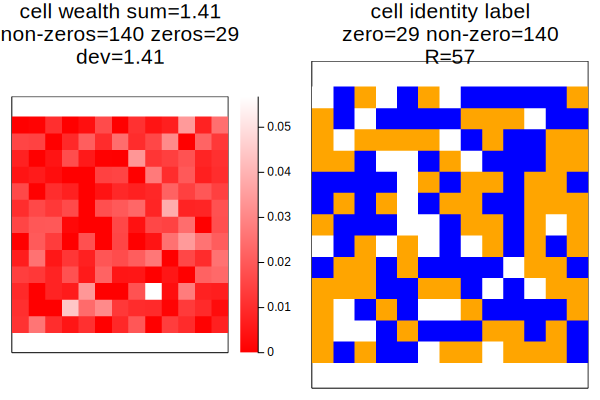


2.0


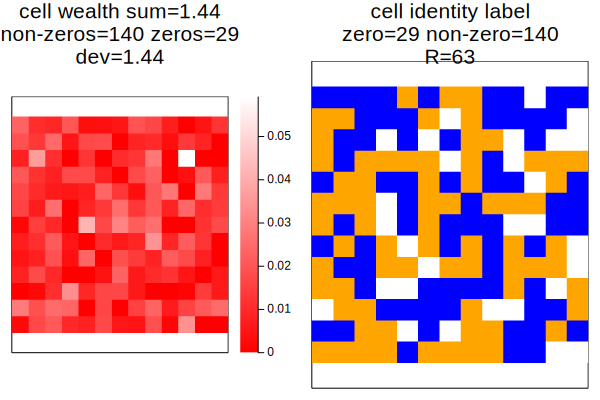

5
2.0000000000000004


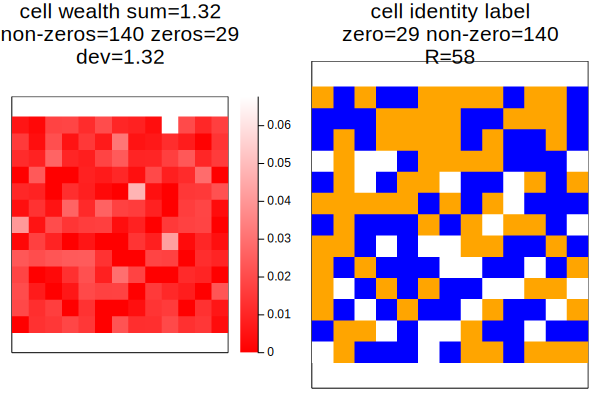

6
1.9999999999999998


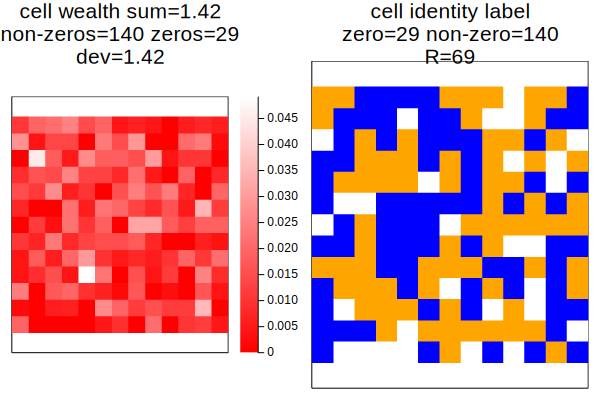

7
2.0
8

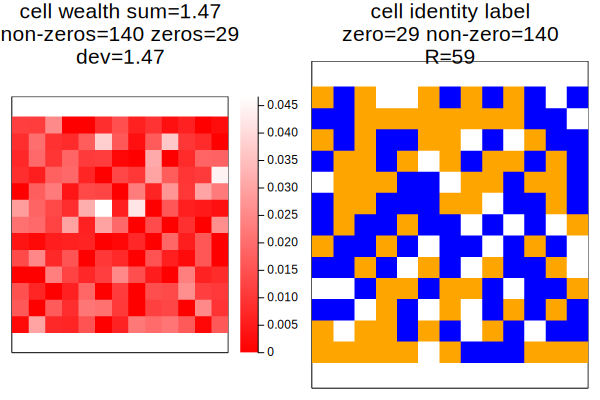


2.0


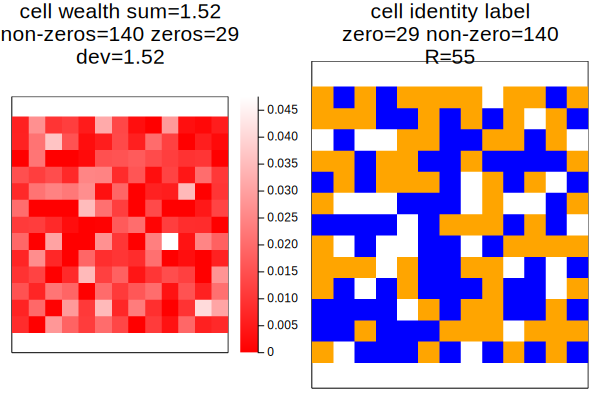

9
2.0
10

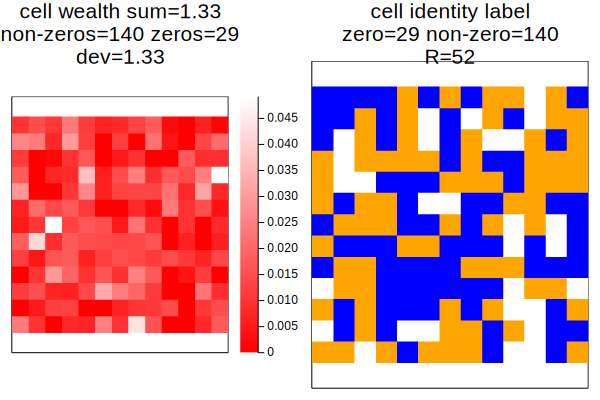


2.0


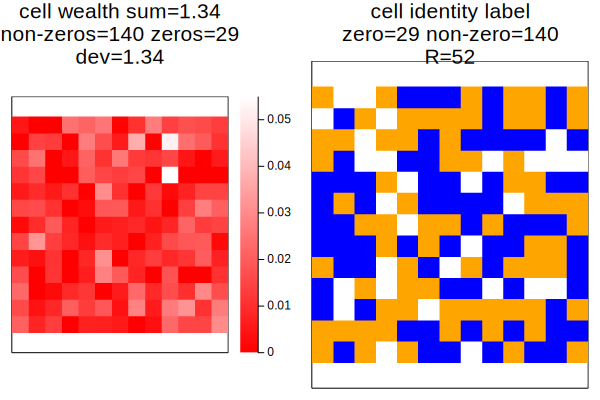

11
2.0
12

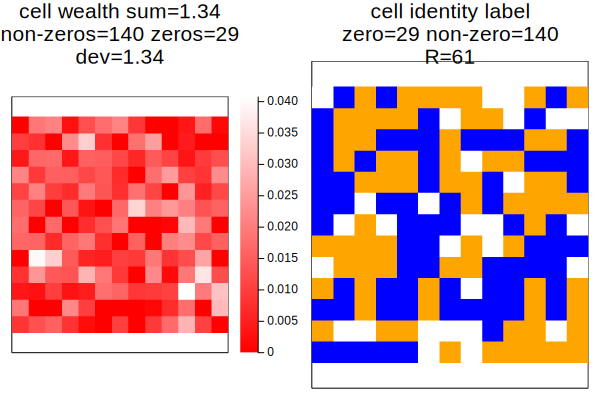


1.9999999999999998
13

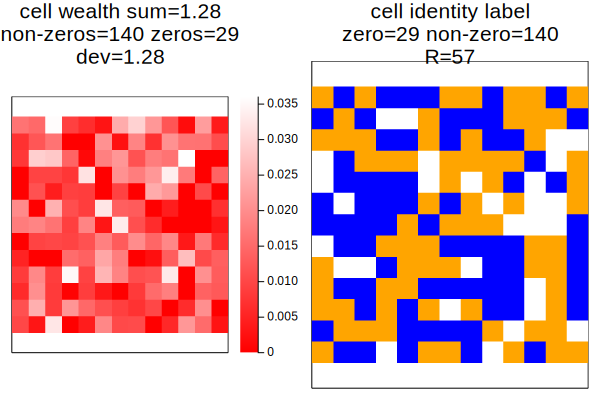


2.0000000000000004
14

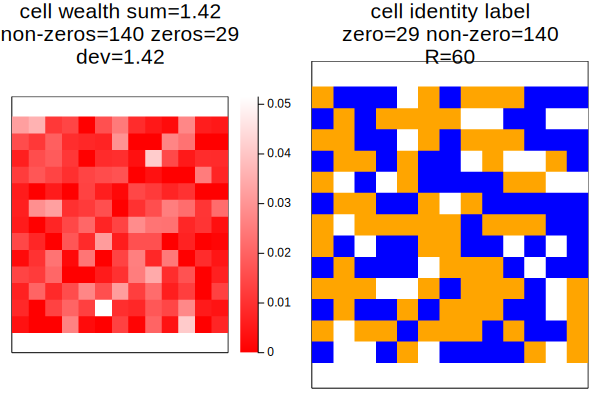


1.9999999999999998
15

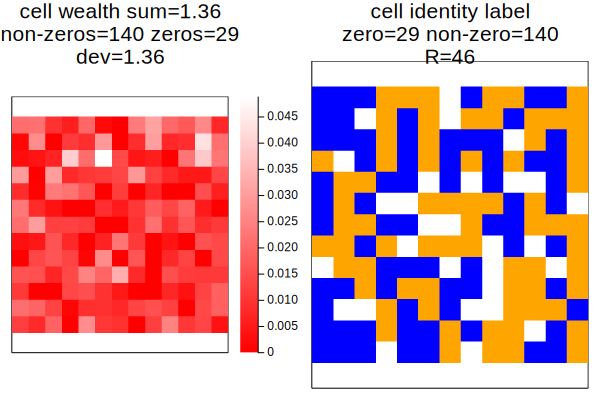


2.0


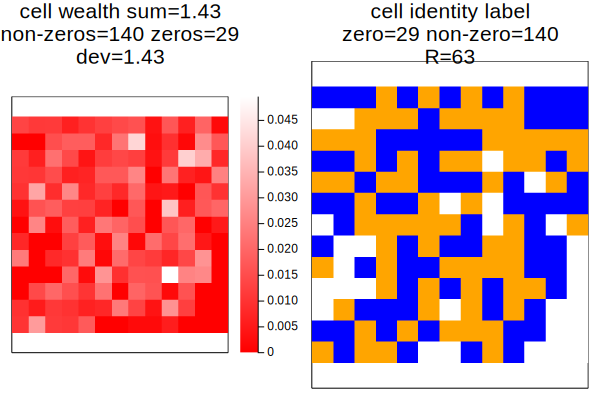

16
2.0
17

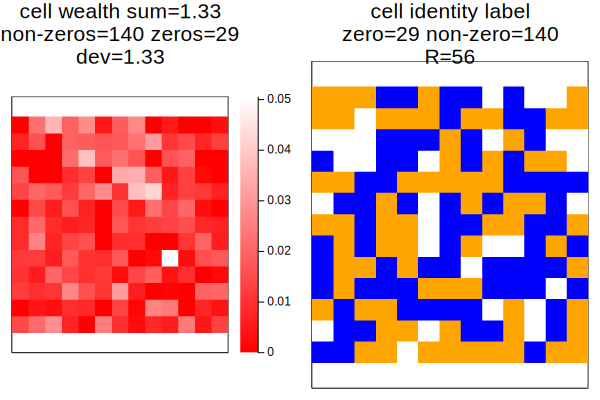


1.9874065784776427
18

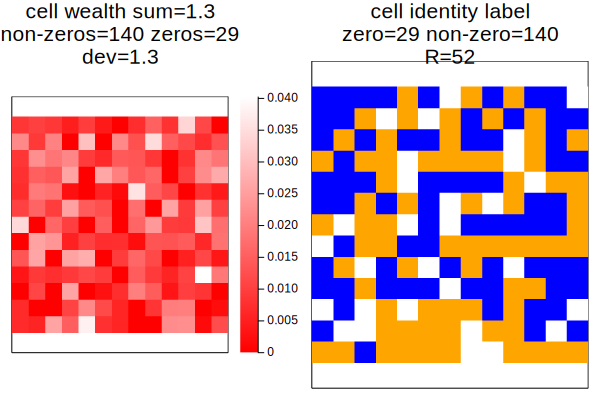


1.9874065784776422
19

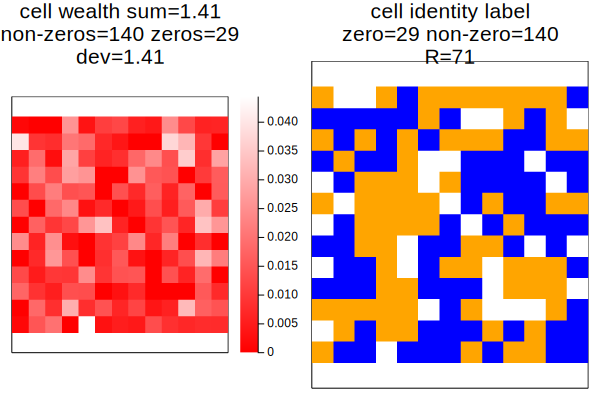


1.9874065784776427
20

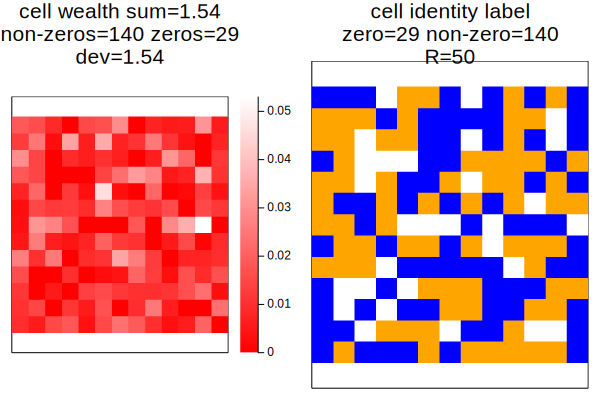


1.9874065784776427
21

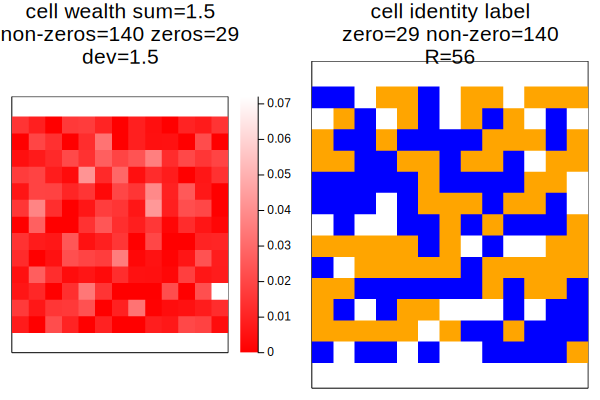


1.9874065784776427
22

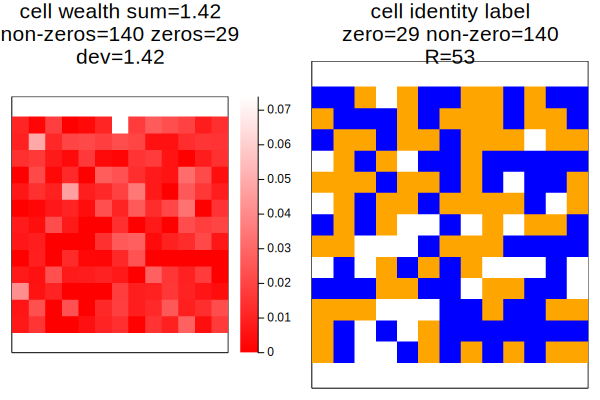


1.9874065784776425
23

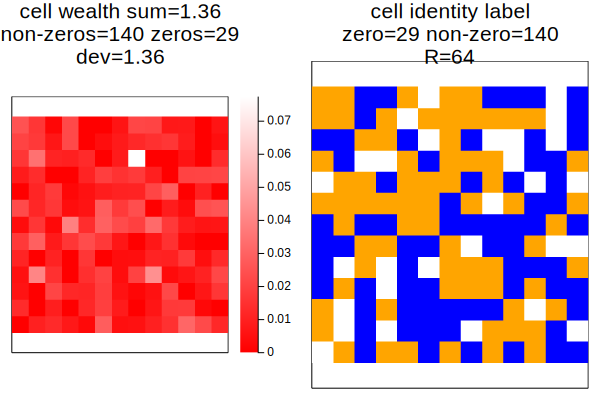


1.9874065784776427
24

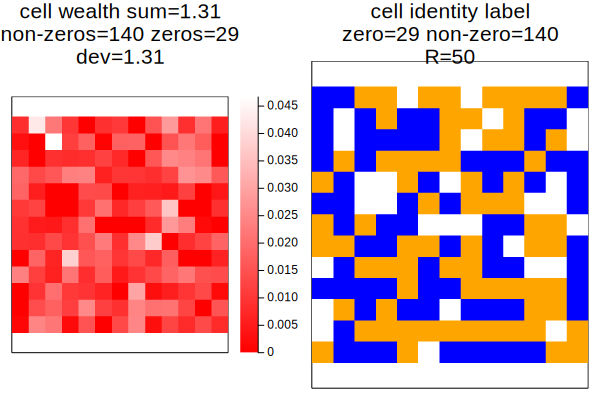


1.9874065784776425
25

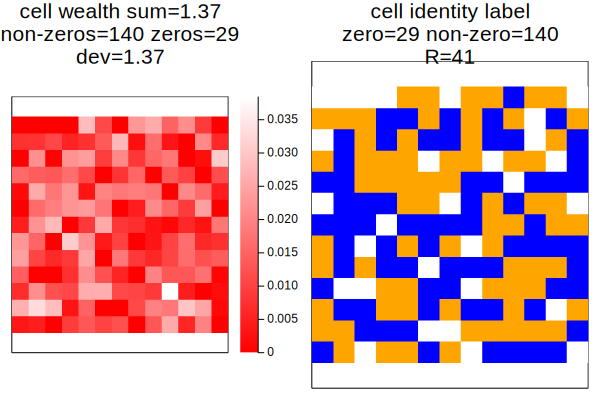


1.9874065784776425
26

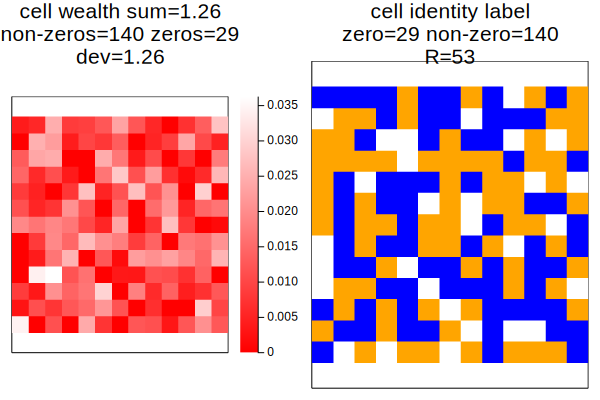


1.9874065784776427
27

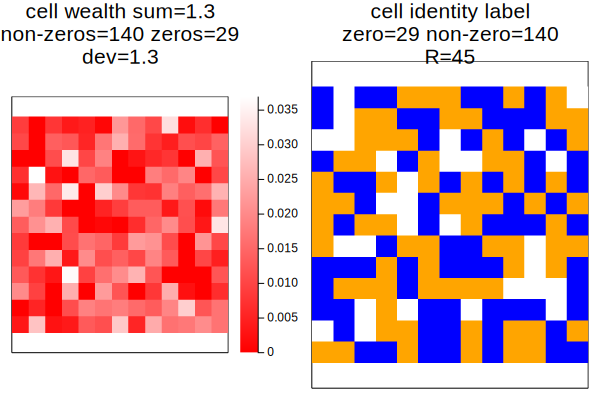


1.9874065784776425
28

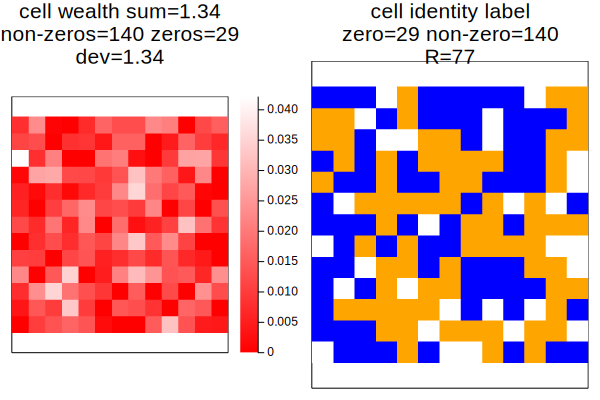


1.987406578477643
29

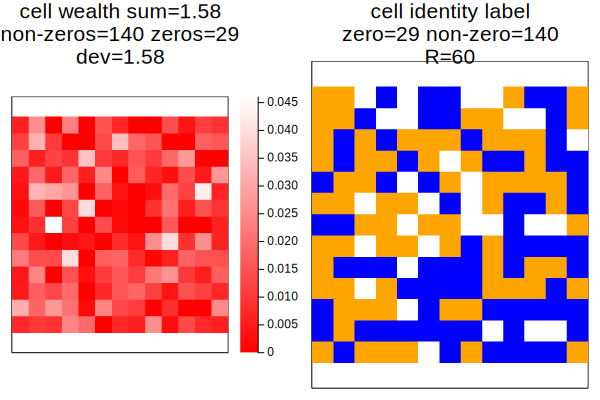


1.9874065784776427
30

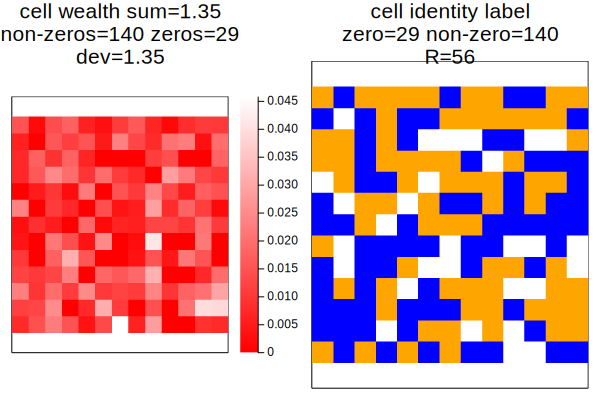


1.9874065784776427


In [262]:
#now that the random moves, and financial dispersion is made... it is time to produce the entropy traces

traceR2 = zeros(TT)
traceWD2 = zeros(TT)
 
for tt in 1:TT   
    println(tt)
    if(tt==1)
        moneyGrid = make_random_finance_grid()  
    else
        moneyGrid =  move_cells_for_wealth_Dynamics1(moneyGrid) #make_random_finance_grid()  
    end          
    println(sum(moneyGrid[:,:,2]))
    traceR2[tt] = grid_satisfaction(moneyGrid[:,:,1])
    traceWD2[tt] = financial_grid_deviation(moneyGrid)
    wdevTmp = financial_grid_deviation(moneyGrid)
    Rtmp = grid_satisfaction(moneyGrid[:,:,1])
    tmp = round(sum(wdevTmp),digits=2)
    tmp2 = length(findall(moneyGrid[:,:,1] .!= 0))
    tmp2b = length(findall(moneyGrid[:,:,1] .== 0))
    tmp3 = length(findall(moneyGrid[:,:,2] .== 0))
    tmp4 = length(findall(moneyGrid[:,:,2] .!= 0))
    
    hm = heatmap(moneyGrid[:,:,2],title="cell wealth sum=$(tmp) \n non-zeros=$(tmp4) zeros=$(tmp3) \n dev=$(round(wdevTmp,digits=2))",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
    c=ColorGradient([:red,:white]))
    hm2 = heatmap(moneyGrid[:,:,1],title="cell identity label \n zero=$(tmp2b) non-zero=$(tmp2) \n R=$(Rtmp)",
        showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
        c=ColorGradient([:orange,:white,:blue]))

    p1=plot(hm,hm2)
    display(p1)
    savefig(hm,"figs/simulationSnapShots3/time$(tt).png")
end


In [263]:
randomMoneyDeviationsData = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
randomMoneyDeviationsData = round.(randomMoneyDeviationsData,digits=roundDigits)
println(mean(randomMoneyDeviationsData))
randomMoneyDeviationsUniform = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
randomMoneyDeviationsUniform = round.(randomMoneyDeviationsUniform,digits=roundDigits)
println(mean(randomMoneyDeviationsUniform))

1.81244
1.4859449999999996


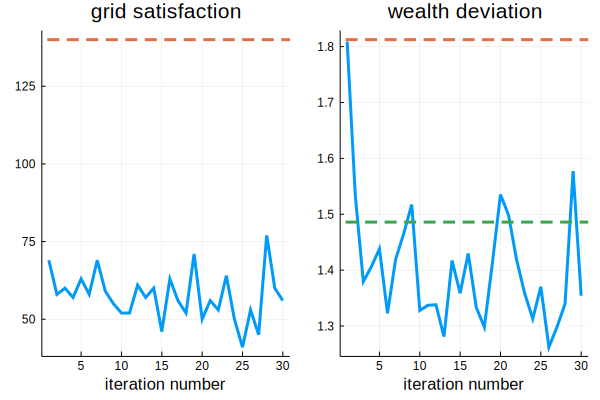

In [264]:
#now the trajectory of the simulation for the finance and the schelling must be done

p1 = plot(traceR2,linewidth=3,title="grid satisfaction",xlabel="iteration number")
hline!([R_MAX],line=(3,:dash),leg=false)
p2 = plot(traceWD2,linewidth=3,title="wealth deviation",xlabel="iteration number")
hline!([mean(randomMoneyDeviationsData)],line=(3,:dash),leg=false)
hline!([mean(randomMoneyDeviationsUniform)],line=(3,:dash),leg=false)
pboth = plot(p1,p2)
display(pboth)
savefig(pboth,"figs/RandWealthDevRandomDynamics1.png")


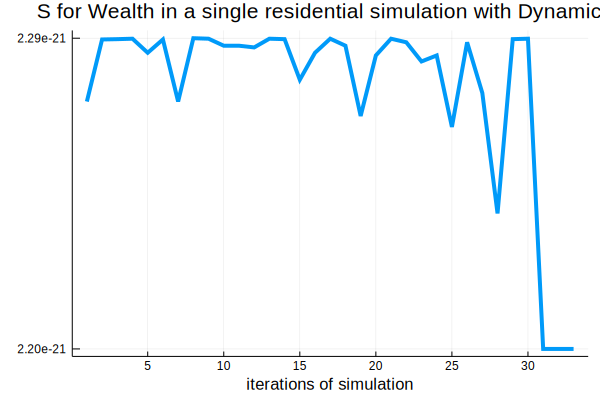

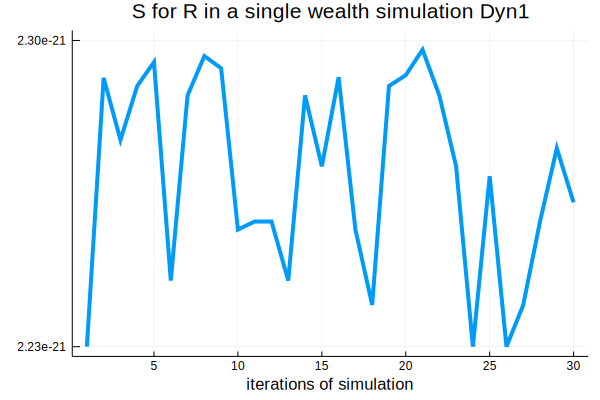

In [352]:
#now calculate the entropy traces for a single simulation

#-------------------#
#residential trace first
traceSv2 = [ S_entropy_values_from_R(Int(rr)) for rr in traceR2]

SMAX = S_entropy_values_from_R(R_MAX)
#println(minimum([traceSv2;SMAX]))
minStr = string(minimum([traceSv2;SMAX]))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(traceSv2)) )
tmp2 = string(minimum(traceSv2))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum([traceSv2;SMAX]))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(traceSv2)) )
tmp2 = string(maximum(traceSv2))[tmp:end]
labelMax = string(maxStr,tmp2)

plt5 = plot(traceSv2,
    yticks=([minimum(append!(traceSv2,SMAX)),maximum([traceSv2;SMAX])],[labelMin,labelMax]),
    ylims=(minimum(append!(traceSv2,SMAX))*(1-(10^-3)),(1 + 10^-3)*maximum(append!(traceSv2,SMAX))),
    linewidth=4,title="S for Wealth in a single residential simulation with Dynamics1",xlabel="iterations of simulation",leg=false)
#hline!([minimum([traceSv2;SMAX])],line=(3,:dash),leg=false)#SMAX)
display(plt5)
savefig(plt5,"figs/entropyRsingleTraceWealthDynamics1.png")


#------------------#
#now for the wealth trace, traceWD2

traceWDrnd2 = round.(traceWD2,digits=2)
indsEntropy2 = map(x->findfirst(x .== binsDev),traceWDrnd2)
entropyTraceW2 = entropyValsW[indsEntropy2]

SMAXW = maximum(entropyValsW)

#=function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end=#
minStr = string(minimum([entropyTraceW2;SMAXW]))[1:4] 
tmp = findfirst( isequal('e') , string(minimum([entropyTraceW2;SMAXW])) )
tmp2 = string(minimum([entropyTraceW2;SMAXW]))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum([entropyTraceW2;SMAXW]))[1:4] 
tmp = findfirst( isequal('e') , string(maximum([entropyTraceW2;SMAXW])) )
tmp2 = string(maximum([entropyTraceW2;SMAXW]))[tmp:end]
labelMax = string(maxStr,tmp2)

plt5 = plot(entropyTraceW2,
    yticks=([minimum([entropyTraceW2;SMAXW]),maximum([entropyTraceW2;SMAXW])],[labelMin,labelMax]),
    ylims=(minimum([entropyTraceW2;SMAXW])*(1-(10^-3)),(1 + 10^-3)*maximum([entropyTraceW2;SMAXW])),
    linewidth=4,title="S for R in a single wealth simulation Dyn1",xlabel="iterations of simulation",leg=false)
#hline!([maximum([entropyTraceW2;SMAXW])],line=(3,:dash),leg=false)#SMAX)
display(plt5)
savefig(plt5,"figs/entropyWsingleTraceWealthDynamics1.png")


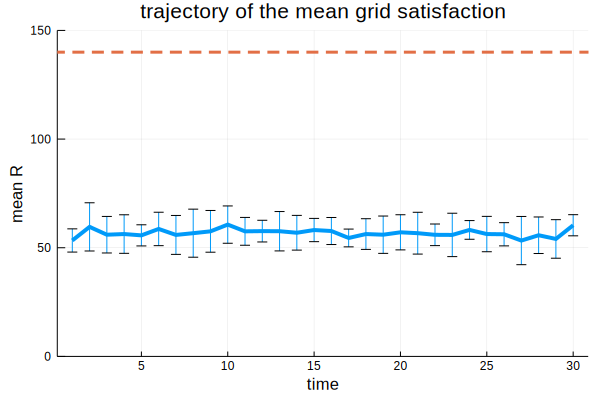

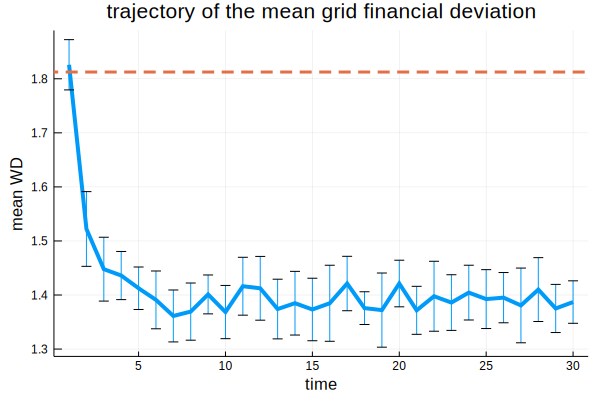

In [343]:
#now do the bulk simulation study for the financial dynamics

simulationRvals2 = zeros(TT,MM)
simulationWvals2 = zeros(TT,MM)
for mm in 1:MM        
    traceRtmp = zeros(TT)
    traceWDtmp = zeros(TT)
    for tt in 1:TT   
        #println(tt)
        if(tt==1)
            moneyGrid = make_random_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_Dynamics1(moneyGrid) #make_random_finance_grid()  
        end    
        traceRtmp[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceWDtmp[tt] = financial_grid_deviation(moneyGrid)        
    end
    simulationRvals2[:,mm] = traceRtmp[:]
    simulationWvals2[:,mm] = traceWDtmp[:]
end

plt = plot(mean(simulationRvals2,dims=2),xlabel="time",ylabel="mean R",
    yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),
    title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)
display(plt)
savefig(plt,"figs/trajectoryMeanGridSatisfactionWithWealthDynamics1.png")

plt = plot(mean(simulationWvals2,dims=2),xlabel="time",ylabel="mean WD",
    yerr=std(simulationWvals,dims=2),linewidth=4,
    title="trajectory of the mean grid financial deviation",leg=false) 
#hline!([R_MAX],line=(3,:dash),leg=false)
hline!([mean(randomMoneyDeviationsData)],line=(3,:dash),leg=false)
#hline!([mean(randomMoneyDeviationsUniform)],line=(3,:dash),leg=false)
display(plt)

savefig(plt,"figs/meanTrajFinancialDeviationDynamics1.png")


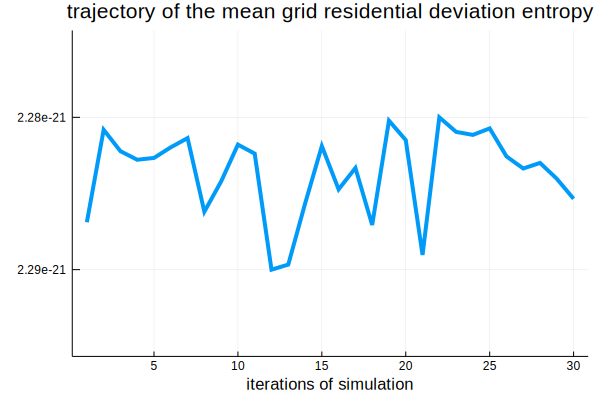

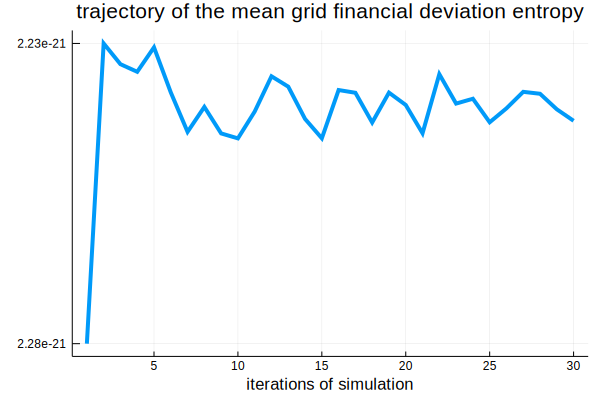

In [351]:
#now the wealth and spatial deviations from a batch simulation with Dynamics1

simulationRvals1 = zeros(TT,MM)
simulationWvals1 = zeros(TT,MM)

for mm in 1:MM        
    traceR = zeros(TT)
    traceWD = zeros(TT)
    for tt in 1:TT   
        #println(tt)
        if(tt==1)
            moneyGrid = make_random_finance_grid()  
        else
            moneyGrid =  move_cells_for_wealth_Dynamics1(moneyGrid) #make_random_finance_grid()  
        end   
        traceR[tt] = grid_satisfaction(moneyGrid[:,:,1])
        traceWD[tt] = financial_grid_deviation(moneyGrid)        
    end
    simulationRvals1[:,mm] = traceR[:]
    simulationWvals1[:,mm] = traceWD[:]
end

simulationRvalsEntropy1 = zeros(TT,MM)
simulationWvalsEntropy1 = zeros(TT,MM)

function entropyTraceWDhelper(wdArray)
    traceWDrnd = round.(wdArray,digits=2)
    indsEntropy = map(x->findfirst(x .== binsDev),traceWDrnd)
    entropyTraceW = entropyValsW[indsEntropy]
    return entropyTraceW
end

function labelMaxMinEntropy(trace)
    minStr = string(minimum(trace))[1:4] 
    tmp = findfirst( isequal('e') , string(minimum(trace)) )
    tmp2 = string(minimum(trace))[tmp:end]
    labelMin = string(minStr,tmp2)
    maxStr = string(maximum(trace))[1:4] 
    tmp = findfirst( isequal('e') , string(maximum(trace)) )
    tmp2 = string(maximum(trace))[tmp:end]
    labelMax = string(maxStr,tmp2)
    return labelMax,labelMin
end

for i in 1:TT
    for j in 1:MM       
        simulationRvalsEntropy1[i,j] = S_entropy_values_from_R(Int(simulationRvals1[i,j] ))
        simulationWvalsEntropy1[i,j] = entropyTraceWDhelper(simulationWvals1[i,j])
    end
end


tmp = labelMaxMinEntropy(mean(simulationRvalsEntropy1,dims=2))
labelMin,labelMax = tmp[1],tmp[2]
plt5 = plot(mean(simulationRvalsEntropy1,dims=2),
    yticks=([minimum(mean(simulationRvalsEntropy1,dims=2)),maximum(mean(simulationRvalsEntropy1,dims=2))],
        [labelMin,labelMax]),#yerr=std(simulationRvalsEntropy1,dims=2),
    ylims=(minimum(mean(simulationRvalsEntropy1,dims=2))*(1-(10^-3)),(1 + 10^-3)*maximum(mean(simulationRvalsEntropy1,dims=2))),
    linewidth=4,title="trajectory of the mean grid residential deviation entropy",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/trajectoryMeanGridSatisfactionResidencyEntropy1.png")

tmp = labelMaxMinEntropy(mean(simulationWvalsEntropy1,dims=2))
labelMin,labelMax = tmp[1],tmp[2]
plt5 = plot(mean(simulationWvalsEntropy1,dims=2),
    yticks=([minimum(mean(simulationWvalsEntropy1,dims=2)),maximum(mean(simulationWvalsEntropy1,dims=2))],
        [labelMin,labelMax]),#yerr=std(simulationWvalsEntropy1,dims=2),
        ylims=(minimum(mean(simulationWvalsEntropy1,dims=2))*(1-(10^-3)),(1 + 10^-3)*maximum(mean(simulationWvalsEntropy1,dims=2))),
    linewidth=4,title="trajectory of the mean grid financial deviation entropy",xlabel="iterations of simulation",leg=false)
display(plt5)
savefig(plt5,"figs/meanTrajFinancialDeviationEntropy1.png")




In [253]:

#savefig(hm,"figs/simulationSnapShots1/time$(tt).png")




#for the sampling of the composite dynamics entropy states

#wealthSamples = [randUniformWealthBracketSample() for i in 1:10]

function make_uniform_sampled_finance_grid2()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    #in the finance grid we store both the type of agent and the financial part
    yellowUniformSample = [randUniformWealthBracketSample() for i in 1:yellow_count]
    blueUniformSample = [randUniformWealthBracketSample() for i in 1:blue_count]

    NORMED = true

    if(NORMED == true)
        wealthSamplesYellowUniformSampled = yellowUniformSample ./ sum(yellowUniformSample)
        wealthSamplesBlueUniformSampled = blueUniformSample ./ sum(blueUniformSample)
        println(wealthSamplesBlueUniformSampled)
    else
        wealthSamplesYellowUniformSampled = yellowUniformSample #./ sum(yellowUniformSample)
        wealthSamplesBlueUniformSampled = blueUniformSample# ./ sum(blueUniformSample)
    end
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= wealthSamplesYellowUniformSampled
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= wealthSamplesBlueUniformSampled
    
    empty_grid[:,:,1] = shuffle(empty_grid[:,:,1])
    empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    return empty_grid
end


moneyGridUniformSampled2 = make_uniform_sampled_finance_grid2();


[0.0301837, 0.0125128, 0.0216362, 0.00330239, 0.00158562, 0.0102046, 0.00809055, 0.000366353, 3.90931e-5, 0.00158991, 0.02679, 0.0132275, 0.0238743, 0.00617805, 0.0280148, 0.0140228, 0.00877047, 0.0041054, 0.00641834, 0.0159938, 0.0199029, 0.0183224, 0.0160146, 0.025295, 0.00395493, 0.0214968, 0.0228731, 0.0300628, 0.0148374, 0.00389473, 0.0258861, 0.0128534, 0.0229192, 0.0129355, 0.00835248, 0.0236068, 0.00141916, 0.00309203, 0.0274243, 0.00167064, 0.000562339, 0.0209858, 0.0186908, 0.0172696, 0.0152255, 0.0157262, 0.0193118, 0.0281774, 0.00997768, 0.00414967, 0.0124035, 0.0128833, 0.0218075, 0.0286678, 0.00741266, 0.0248828, 0.00316654, 0.0168679, 0.0295542, 0.0143199, 0.00664262, 0.0157229, 0.00654927, 0.0265318, 0.0282671, 0.0113655, 0.012961, 0.00135738, 0.00389577, 0.0109431]


In [44]:

##just make a function to move the sampled agents around and see if the deviation is altered
#take the trace over time and since thre is no dynamics move one cell randomly at a time 
#but they do still radiate their money randomly and uniformly upon their destination locality
#where they end up, plot hlines for the means of the the two histograms above
#look at the results for starting with the uniform and real data to see if the deviation goes up or down...
#then do the randoml movement but people only move into areas where they have more than the median of
#the locality. and 
#on arrival disperse radially a random percentage of their wealth around them.
#check the median and mean deviations for th grid overt that time and check to see if it locks as
#if there is a point where the movement stops. 

#schelling said that the small changes in probability can have drastic effects. and that these
#preferencces can be so small that even the agents themselves the residents are not 
#aware of their biases because of the effects on the macrostate examining individuals
#may not be a viable solution. Therefore examining the macrostate and the change in the
#entropy would be a more sensitive and reslient approach. the minor amplificiations on
#the agent level can produce massive combinational changes on the macrostate.
#it also reacts quickly!

#the radial disperal at the start is benign, but afterwards the high wealth individuals
#create a block for the low to now enter like in physics for the satisfaction of new
#molecular bonds in how satisfied they will be. That is the same as 'gentrification'
 
#we get wealth samples, and sample from that for the allocations and then the wealth on movement 
#that here is initially random that gets radially distributed.
#how many random allocations of the financial units would it take to arrive at the 
#distribution of the wealth indicators
#eg, we start out with wealth sampled from the CDF, we allocate them to the residents. 
#they then move around randomly without homogeneity search
#we then do a set of random allocations of the funds to get a distribution for the variance 
#of the wealth and the skew so that we can say that the macro state variable is the variance and skew

#later we do the model that has both the homogeneity and the financial indicators and get the macrostate trajectory

#question: we need to have the purchasing to be constrained so that they cannot move forever 
#or that we can regulated it according to the size of the system.
#if tons of wealth is dropped it can go forever? or can we say that the wealth 
#movement is a relative measure? the relative measure would be more robust but the constrained version
#should also work.

In [45]:
#now to find a model that respects an increasing entropy value trace
#now to do the financial part...


#when an agent moves into a new place, they subtract the averagej from themselves
#and distribute that radially amongst the surrounding people.

#what is the accumulated gaps (disparity) ....of the wealth on the local levels..! :)
#take the min and max due to corners, then we keep that difference, and take the accumulation 
#of the total differences
#we simply compare that aggregate to the aggregates of the random initial samples...



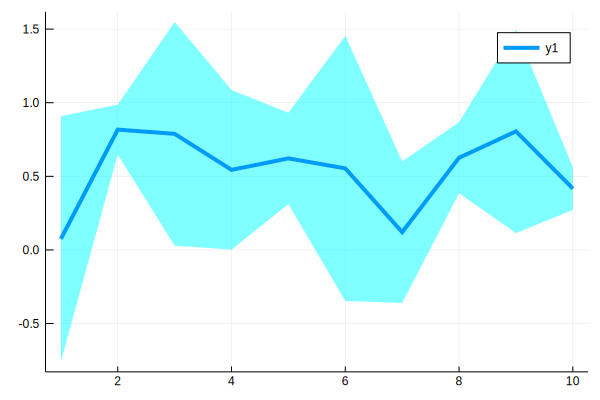

In [46]:
 plot(rand(10),ribbon=rand(10),fill=:cyan,linewidth=4)

In [47]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [48]:
x=3
println(f1(x))

18


$$\lambda + \beta$$
$$\frac{12}{4}$$

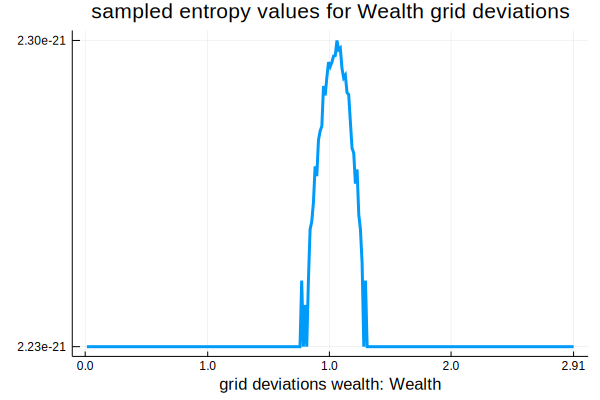

291
2.30e-212.23e-21
random grid satisfactionOLD value=78
set grid satisfactionOLD value=140


In [49]:


function S_entropy_values_from_WD(W)
    return k_b * log(sampleOmegaWD[W])
       
end

entropyValsW = [S_entropy_values_from_WD(W) for W in 1:length(moneyDeviationBins)]
println(length(entropyValsW))
#println((entropyValsW))

minStr = string(minimum(entropyValsW))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyValsW)) )
tmp2 = string(minimum(entropyValsW))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyValsW))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyValsW)) )
tmp2 = string(maximum(entropyValsW))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

strTmp0 = string(0*SEPBIN)
tmp0 = 0
strTmp1 = string(round( length(moneyDeviationBins)* 1/4  * SEPBIN))
tmp1 = round( length(moneyDeviationBins)* 1/4 )
strTmp2 = string(round( length(moneyDeviationBins)* 2/4  * SEPBIN))
tmp2 = length(moneyDeviationBins)* 2/4 
strTmp3 = string(round( length(moneyDeviationBins)* 3/4  * SEPBIN))
tmp3 = round( length(moneyDeviationBins)* 3/4 )
strTmp4 = string(length(moneyDeviationBins)*SEPBIN)
tmp4 = length(moneyDeviationBins)

pltSW = plot(1:length(moneyDeviationBins),entropyValsW,
    yticks=([minimum(entropyValsW),maximum(entropyValsW)],[labelMin,labelMax]),
    xticks=([0 tmp1 tmp2 tmp3 tmp4],
        [strTmp0 strTmp1 strTmp2 strTmp3 strTmp4]),
    ylim=(minimum(entropyValsW)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyValsW)),
    linewidth=3,title="sampled entropy values for Wealth grid deviations",xlabel="grid deviations wealth: Wealth",
    leg=false)
display(pltSW)
savefig(pltSW,"figs/entropyWdistribution.png")


#old code


function grid_satisfactionOLD(start_grid) 
cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            cell_surrounding = []
            if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
                for ii in 0:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
                for ii in 0:1
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==1))#top left corner
                for ii in 1:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==GRID_SIZE))#top right corner
                for ii in 1:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==1))#bottom left corner
                for ii in 0:1
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
                for ii in 1:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
                for ii in 0:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
                for ii in 0:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
                for ii in 0:1
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
        end
    end
#println(cell_satisfaction)
#println(size(cell_satisfaction))
#println(sum(cell_satisfaction))

    return sum(cell_satisfaction)
end

satisfiedOneGrid = grid_satisfactionOLD(start_grid)
println("random grid satisfactionOLD value=",satisfiedOneGrid)
R_MAX = grid_satisfactionOLD(set_grid)
println("set grid satisfactionOLD value=",R_MAX)

In [50]:

#=
moneyGrid2 = move_cells_for_wealth_NoDynamics(moneyGrid)

println("---")
println("number of empty resident cells=",length(findall(moneyGrid2[:,:,1] .== 0)))
println("nmber of empty finance cells=",length(findall(moneyGrid2[:,:,2] .== 0)))
println("sum of total finance on finance cells=",sum(moneyGrid2[:,:,2]) )  
println("grid the same as before for residential=",moneyGrid2[:,:,1] == moneyGrid[:,:,1])
println("grid the same as before for finance=",moneyGrid2[:,:,2] == moneyGrid[:,:,2])
println("financial grid deviation=",financial_grid_deviation(moneyGrid))
println("financial grid2 deviation=",financial_grid_deviation(moneyGrid2))
println("grid2 satisfaction=",grid_satisfaction(moneyGrid2[:,:,1]))
println("---")

wdevTmp = round(financial_grid_deviation(moneyGrid2),digits=2)    
Rtmp = grid_satisfaction(moneyGrid2[:,:,1])
hm = heatmap(moneyGrid2[:,:,2],title="cell wealth \n deviation=$(wdevTmp)",
showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,
    framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=true,
c=ColorGradient([:red,:white]))
hm2 = heatmap(moneyGrid2[:,:,1],title="cell identity label \n R=$(Rtmp)",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

p2=plot(hm,hm2)
display(p2)
#savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
=#
#find neighbor number
    #=cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                if(grid[row-1+(ii),(col-1)+(jj)] != 0) 
                    append!(cell_surrounding,abs(grid[row-1+(ii),(col-1)+(jj)]))              
                end
            end
        end
    end=#